Autores: ....

### EDA

#### Normalización de datos y validación

* Utilizamos info() para revisar la estructura y los tipos de datos del conjunto.
    * Los detalles concretos con shape, columns o dtypes.
* Clasificación de región en Regiones y Ciudades
* Explorar datos, fechas, nulos, columnas innecesarias
* Discusión sobre qué hacer con los datos de semanas que faltan (interpolante)

##### Mostrar la estructura de datos del dataset avocados

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import avocado_manager as av
av.init()
df_cp = av.df("df_cp")
print(df_cp.info())

df_cp_cleaned = df_cp
df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S' ]+ df_cp_cleaned['Volume_Hass_L']+ df_cp_cleaned['Volume_Hass_XL' ]
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums'])*100/df_cp_cleaned['Total Volume']
av.add(df_cp_cleaned,'df_cleaned')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           18249 non-null  int64         
 1   Date            18249 non-null  datetime64[ns]
 2   AveragePrice    18249 non-null  float64       
 3   Total Volume    18249 non-null  float64       
 4   Volume_Hass_S   18249 non-null  float64       
 5   Volume_Hass_L   18249 non-null  float64       
 6   Volume_Hass_XL  18249 non-null  float64       
 7   Total Bags      18249 non-null  float64       
 8   Small Bags      18249 non-null  float64       
 9   Large Bags      18249 non-null  float64       
 10  XLarge Bags     18249 non-null  float64       
 11  type            18249 non-null  object        
 12  year            18249 non-null  int64         
 13  region          18249 non-null  object        
 14  region_class    18249 non-null  object        
 15  Su

In [58]:
data_shape = df_cp.shape
print(f"\nForma del DataFrame (filas, columnas): {data_shape}")

column_names = df_cp.columns
print(f"\nNombres de Columnas: {column_names}")
 
data_types = df_cp.dtypes
print(f"\nTipos de datos de cada columna:\n{data_types}")


Forma del DataFrame (filas, columnas): (18249, 17)

Nombres de Columnas: Index(['index', 'Date', 'AveragePrice', 'Total Volume', 'Volume_Hass_S',
       'Volume_Hass_L', 'Volume_Hass_XL', 'Total Bags', 'Small Bags',
       'Large Bags', 'XLarge Bags', 'type', 'year', 'region', 'region_class',
       'Suma Volums', 'Variacio'],
      dtype='object')

Tipos de datos de cada columna:
index                      int64
Date              datetime64[ns]
AveragePrice             float64
Total Volume             float64
Volume_Hass_S            float64
Volume_Hass_L            float64
Volume_Hass_XL           float64
Total Bags               float64
Small Bags               float64
Large Bags               float64
XLarge Bags              float64
type                      object
year                       int64
region                    object
region_class              object
Suma Volums              float64
Variacio                 float64
dtype: object


##### Nuestra clasifiacion de clases de regiones

In [59]:
print("Nuestra clasifiacion de clases de regiones:",pd.unique(df_cp['region_class']))
display(df_cp.head(5))

Nuestra clasifiacion de clases de regiones: ['City' 'Region' 'GreaterRegion' 'TotalUS']


index       Date  AveragePrice  Total Volume  Volume_Hass_S  Volume_Hass_L  \
0      0 2015-12-27          1.33      64236.62        1036.74       54454.85   
1      1 2015-12-20          1.35      54876.98         674.28       44638.81   
2      2 2015-12-13          0.93     118220.22         794.70      109149.67   
3      3 2015-12-06          1.08      78992.15        1132.00       71976.41   
4      4 2015-11-29          1.28      51039.60         941.48       43838.39   

   Volume_Hass_XL  Total Bags  Small Bags  Large Bags  XLarge Bags  \
0           48.16     8696.87     8603.62       93.25          0.0   
1           58.33     9505.56     9408.07       97.49          0.0   
2          130.50     8145.35     8042.21      103.14          0.0   
3           72.58     5811.16     5677.40      133.76          0.0   
4           75.78     6183.95     5986.26      197.69          0.0   

           type  year  region region_class  Suma Volums   Variacio  
0  conventional  2015  Albany         City     55539.75  13.538804  
1  conventional  2015  Albany         City     45371.42  17.321580  
2  conventional  2015  Albany         City    110074.87   6.889980  
3  conventional  2015  Albany         City     73180.99   7.356630  
4  conventional  2015  Albany         City     44855.65  12.115984

##### Mostrar las regions top 10 por Total Volume

In [60]:
df_totales = df_cp.groupby('region')['Total Volume'].sum().reset_index()
display(df_totales.nlargest(10,'Total Volume').sort_values(by='Total Volume', ascending = False))
#df_largest = av.df("region_largest")
#display(df_largest)

region  Total Volume
51       TotalUS  5.864740e+09
52          West  1.086779e+09
6     California  1.028982e+09
45  SouthCentral  1.011280e+09
29     Northeast  7.132809e+08
46     Southeast  6.152384e+08
15    GreatLakes  5.896425e+08
25      Midsouth  5.083494e+08
22    LosAngeles  5.078965e+08
35        Plains  3.111885e+08

##### Identificar fechas faltantes por cada region

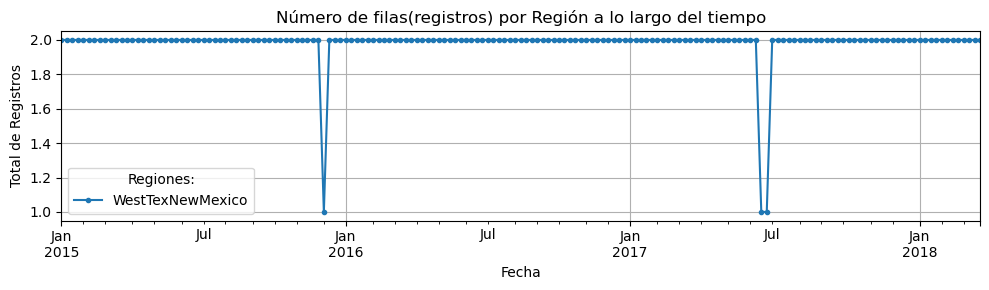

In [61]:
df_count = df_cp.groupby(['Date', 'region']).size().reset_index(name='Total')
df_pivot = df_count.pivot(index='Date', columns='region', values='Total').fillna(0)
diferencias = df_pivot.apply(lambda x: x.nunique() > 1, axis=0)

regiones_con_diferencias = diferencias[diferencias].index.tolist()
df_pivot[regiones_con_diferencias].plot(kind='line', marker='.',figsize=(10, 3))
plt.title('Número de filas(registros) por Región a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Total de Registros')
plt.legend(title='Regiones:')
plt.grid(); plt.tight_layout() #plt.xticks(rotation=90)
plt.show()

##### Análisis exploratorio para entender la estructura del conjunto, incluyendo el número de filas y columnas, tipos de datos y valores faltantes. 

* Imprime la cantidad de valores faltantes por columna utilizando isnull().

In [62]:
print(f"Cantidad de nulls: {df_cp.isnull().sum()}")
#df.isnull
#missing_values = pd.isnull(df)

# Resumen Estadístico
data_summary = df_cp.describe()
print("\nResumen Estadístico:")
print(data_summary)

# series de tiempo
print("\nseries de tiempo:")
df_cp['Date'] = pd.to_datetime(df_cp['Date'])
ventas_mensual = df_cp.groupby(df_cp['Date'].dt.to_period("M"))['Total Volume'].sum().reset_index()
display(ventas_mensual)

Cantidad de nulls: index             0
Date              0
AveragePrice      0
Total Volume      0
Volume_Hass_S     0
Volume_Hass_L     0
Volume_Hass_XL    0
Total Bags        0
Small Bags        0
Large Bags        0
XLarge Bags       0
type              0
year              0
region            0
region_class      0
Suma Volums       0
Variacio          0
dtype: int64

Resumen Estadístico:
              index                           Date  AveragePrice  \
count  18249.000000                          18249  18249.000000   
mean    9124.000000  2016-08-13 23:30:43.498273792      1.405978   
min        0.000000            2015-01-04 00:00:00      0.440000   
25%     4562.000000            2015-10-25 00:00:00      1.100000   
50%     9124.000000            2016-08-14 00:00:00      1.370000   
75%    13686.000000            2017-06-04 00:00:00      1.660000   
max    18248.000000            2018-03-25 00:00:00      3.250000   
std     5268.176867                            NaN      0.4026

Date  Total Volume
0   2015-01  3.180852e+08
1   2015-02  3.626376e+08
2   2015-03  4.185831e+08
3   2015-04  3.441444e+08
4   2015-05  4.837840e+08
5   2015-06  3.818267e+08
6   2015-07  3.567019e+08
7   2015-08  4.192448e+08
8   2015-09  3.292188e+08
9   2015-10  3.057761e+08
10  2015-11  3.694400e+08
11  2015-12  2.960259e+08
12  2016-01  4.754058e+08
13  2016-02  4.286458e+08
14  2016-03  3.912124e+08
15  2016-04  4.018328e+08
16  2016-05  5.612305e+08
17  2016-06  4.103282e+08
18  2016-07  4.672753e+08
19  2016-08  3.707970e+08
20  2016-09  3.623033e+08
21  2016-10  3.602018e+08
22  2016-11  2.602093e+08
23  2016-12  3.314478e+08
24  2017-01  5.333330e+08
25  2017-02  4.714672e+08
26  2017-03  3.589034e+08
27  2017-04  4.898145e+08
28  2017-05  4.257305e+08
29  2017-06  4.104107e+08
30  2017-07  4.749037e+08
31  2017-08  3.383330e+08
32  2017-09  2.847795e+08
33  2017-10  3.627780e+08
34  2017-11  3.245193e+08
35  2017-12  4.593329e+08
36  2018-01  4.297071e+08
37  2018-02  4.977782e+08
38  2018-03  4.552531e+08

#### Visión global de datos

* Analisis de Series Temporales y Ruido asociado
* Precios promedio calibre 
* Precios promedio por bolsa
* Proporcion por tipo de bolsa
* Separar avocados convencional y organics
* Comparación precios promedio convencional y organico
* Representación de ventas totales sobre precio promedio ( por regiones o no )

##### Analisis de Series Temporales y Ruido asociado
Observaciones:

* TODO: Perido de 52 semanas para ver la evolucion a la lo largo de los 3 años ?

Ragos de fechas: mínima: 2015-01-04 00:00:00 máxima: 2018-03-25 00:00:00


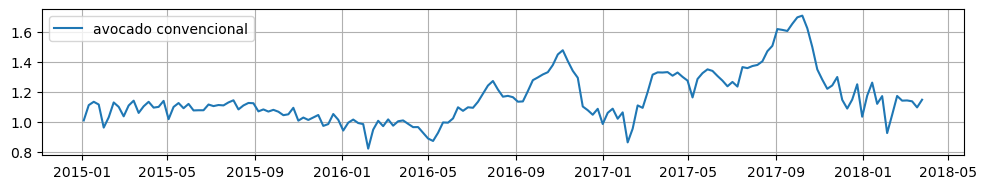

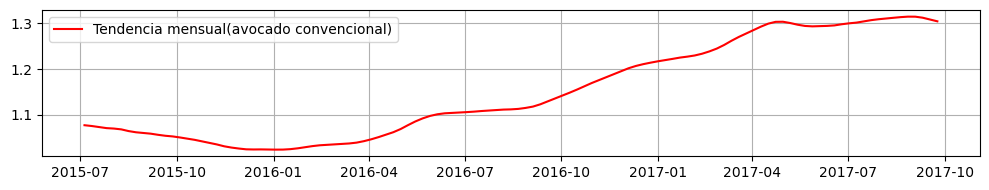

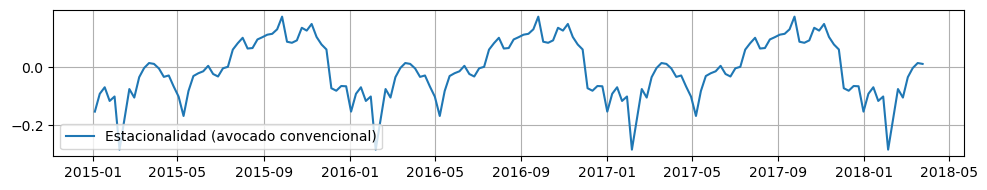

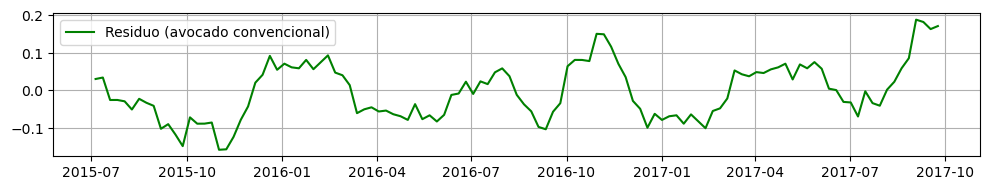

In [63]:
print(f"Ragos de fechas: mínima: {df_cp.Date.min()} máxima: {df_cp.Date.max()}")

df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()
df_cp_conventional = df_cp[df_cp['type'] =='conventional']#[['Date', 'AveragePrice']]
df_grouped = df_cp_conventional.groupby('Date')['AveragePrice'].mean()

# Descomposicio de la serie de tiemps: 39 mesos si considerem que tenim del 1-1-2015 fins al 25-3-2018
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(52*1)) #maxim: 84

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.observed, label='avocado convencional')
plt.legend(loc='best');plt.grid(True)
#plt.title('Tendencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.trend, color='red', label='Tendencia mensual(avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Tendencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.seasonal, label='Estacionalidad (avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Estacionalidad')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.resid, color='green', label='Residuo (avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Residuo')
plt.tight_layout()
plt.show()

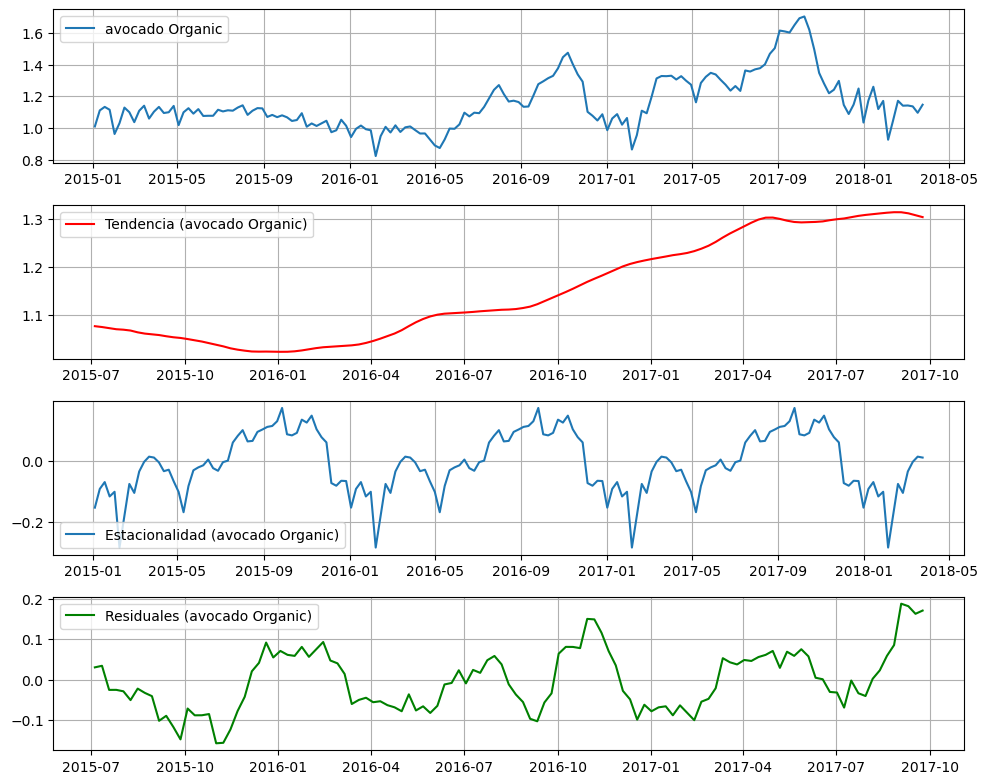

In [64]:
#print("Organic")
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()
df_cp_organic = df_cp[df_cp['type'] =='organic']
df_grouped = df_cp_conventional.groupby('Date')['AveragePrice'].mean()
# Descomposicio de la serie de tiemps: 39 mesos si considerem que tenim del 1-1-2015 fins al 25-3-2018
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(52*1)) #maxim: 84
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(df_grouped, label='avocado Organic')
plt.legend(loc='best');plt.grid(True)
plt.subplot(412)
plt.plot(df_decomp.trend, color='red', label='Tendencia (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.subplot(413)
plt.plot(df_decomp.seasonal,label='Estacionalidad (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.subplot(414)
plt.plot(df_decomp.resid, color='green',label='Residuales (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.tight_layout()
plt.show()

##### Precios promedio calibre 

##### Precios promedio por bolsa

##### Proporcion por tipo de bolsa

<AxesSubplot: xlabel='region'>

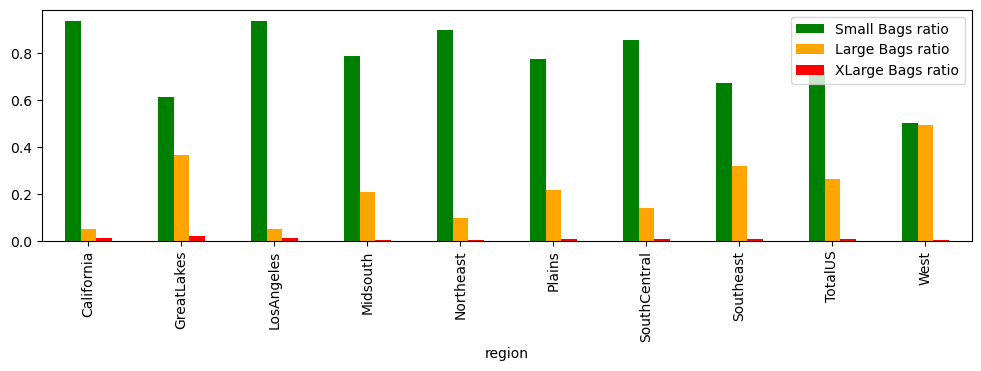

In [65]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

fig, ax= plt.subplots(figsize=(12,3))
ratio_bag=df_baggy.groupby('region')[['Small Bags ratio','Large Bags ratio', 'XLarge Bags ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )

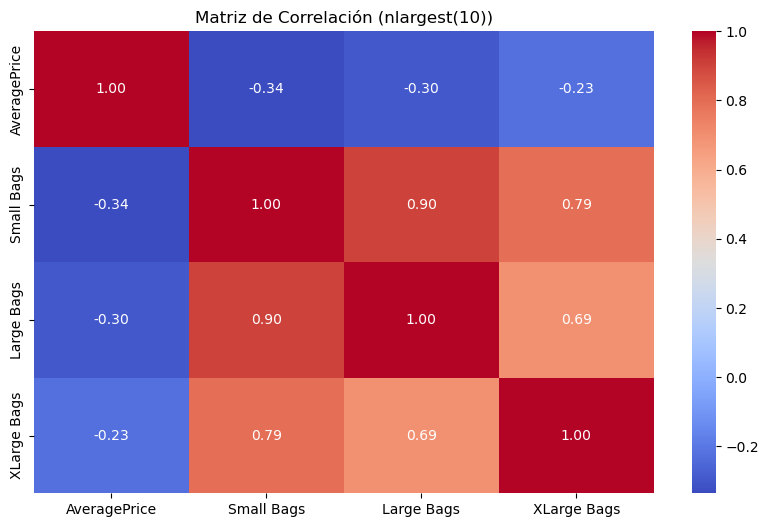

Variables altamente correlacionadas con otras: ['Small Bags', 'Large Bags']


In [66]:
corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (nlargest(10))')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

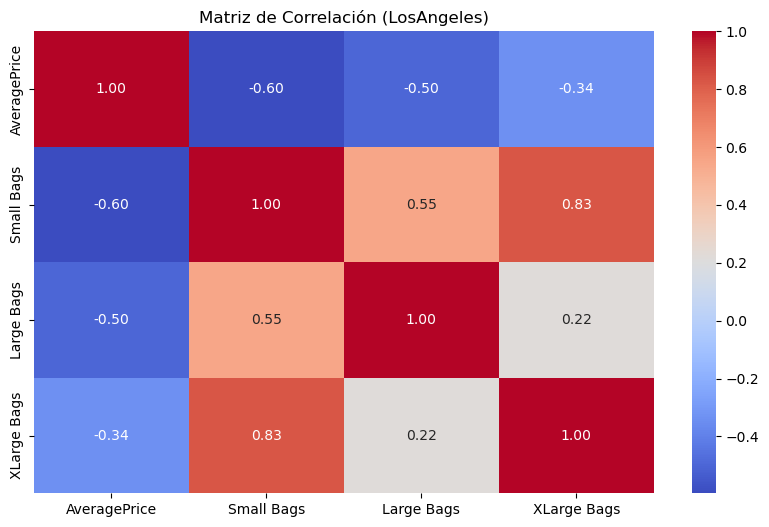

Variables altamente correlacionadas con otras: ['Small Bags', 'XLarge Bags']


In [67]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

df_baggy=df_baggy[df_baggy['region']=='LosAngeles']

corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (LosAngeles)')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Precio medio y volumen total
Observaciones:
* TODO: Estamos mostrado los de tipo convencional. Que es el grupo de puntos de la parte superior ?

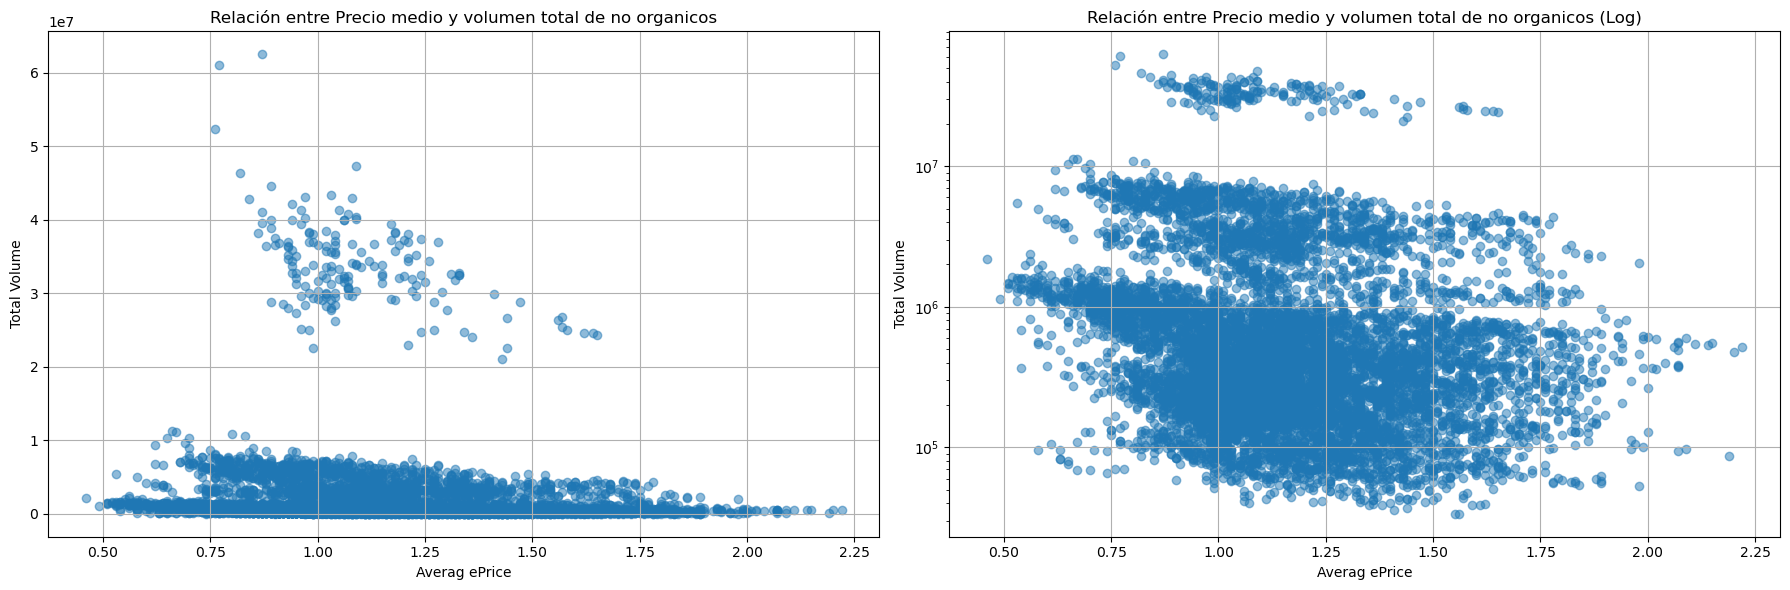

In [68]:
df_cp_tmp = df_cp[df_cp['type']=='conventional']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
ax[0].set_title('Relación entre Precio medio y volumen total de no organicos')
ax[0].set_xlabel('Averag ePrice')
ax[0].set_ylabel('Total Volume')
ax[0].grid()

ax[1].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
ax[1].set_title('Relación entre Precio medio y volumen total de no organicos (Log)')
ax[1].set_xlabel('Averag ePrice')
ax[1].set_ylabel('Total Volume')
ax[1].grid()
ax[1].set_yscale('log')

plt.tight_layout()
# df_cp.groupby(by=['region']).count()

##### Separar avocados convencional y organics
Observaciones:
* TODO: Aqui es veu clarament que el alvocat més relevant es el convencional per ordres de magnitud, per ho que seria relevant fer algún estudi del subset eliminant els organics o estudian-los per separat.
* Addicionalment, l'any 2018 no esta complert, pot afectar a les dades.

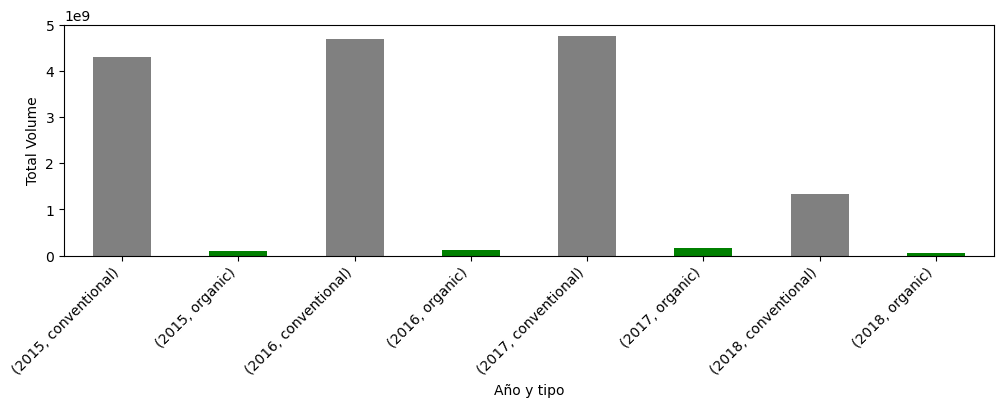

In [69]:
grouped = df_cp.groupby(['year', 'type'])['Total Volume'].sum()
fig, ax= plt.subplots(figsize=(12,3))
grouped.plot(kind='bar', color=['grey', 'green'])
plt.xlabel('Año y tipo')
plt.ylabel('Total Volume')
plt.xticks(rotation=45, ha='right')
plt.show()

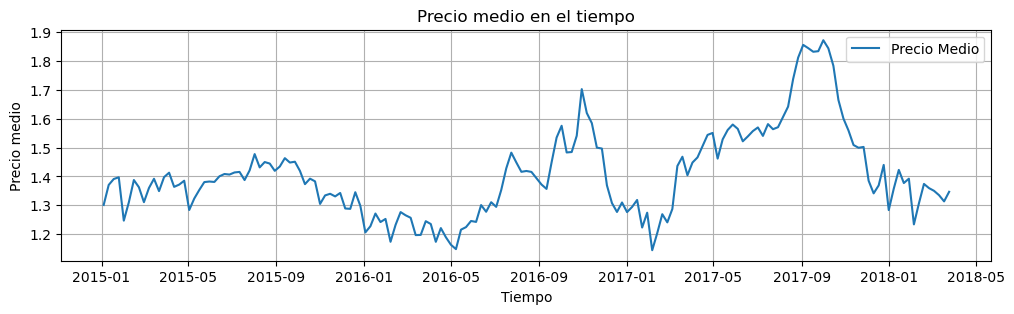

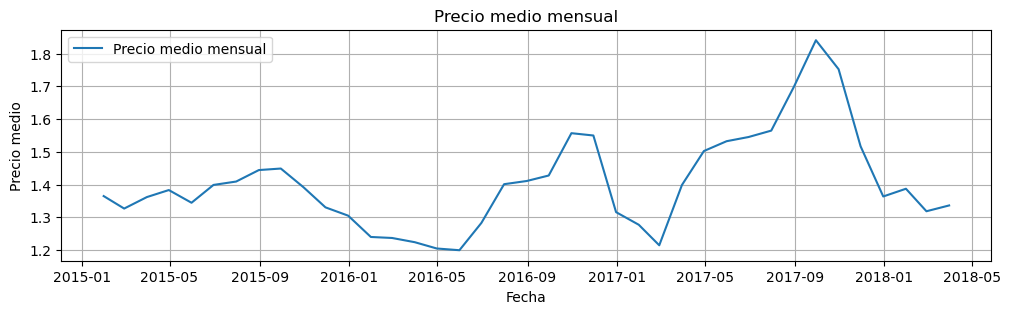

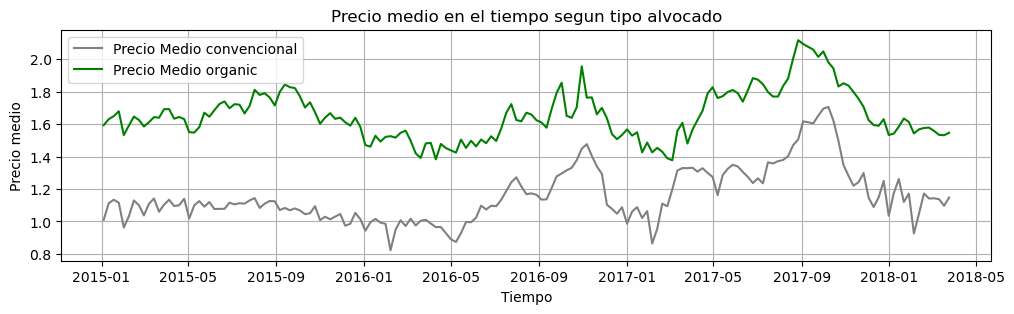

In [70]:
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped, label ='Precio Medio')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_grouped = df_cp.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean()
plt.figure(figsize=(12,3))
plt.plot(df_grouped, label='Precio medio mensual') #plt.plot(df_grouped.index, df_grouped.values)
plt.legend(loc='best')
plt.xlabel('Fecha')
plt.ylabel('Precio medio')
plt.title('Precio medio mensual')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_cp_conventional = df_cp[df_cp['type'] =='conventional'] #[['Date', 'AveragePrice']]
df_grouped_conv = df_cp_conventional.groupby('Date')['AveragePrice'].mean()

df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
df_grouped_orga = df_cp_organic.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped_conv, label ='Precio Medio convencional', color ='grey')
plt.plot(df_grouped_orga, label ='Precio Medio organic', color ='green')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo segun tipo alvocado')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

#df_grouped

##### Comparación precios promedio convencional y organico
Observaciones:
* TODO: Aqui veiem que existeixen unes regions mes relevants que altres. Caldria fer una separació?
* TODO: Excloure TotalUS ??

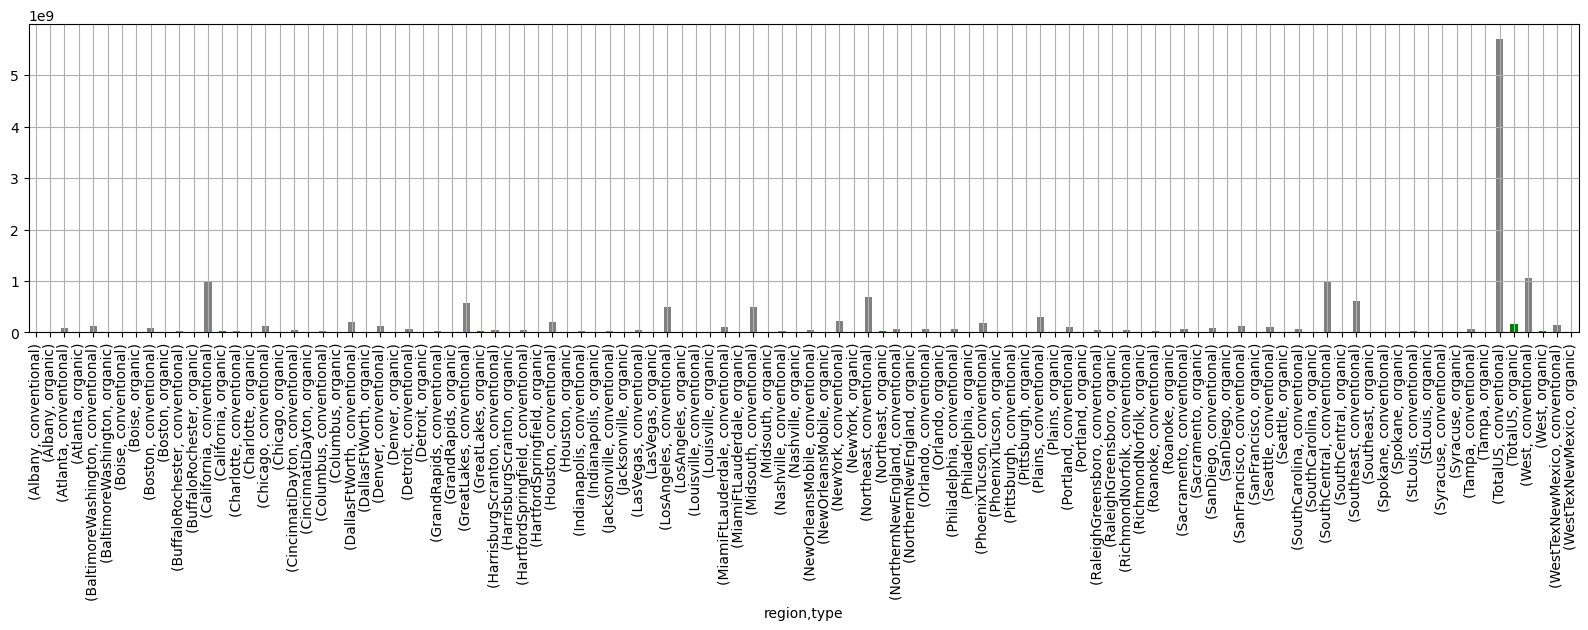

In [71]:
df_subset = df_cp
#df_subset = df_cp[df_cp['region']!= 'TotalUS']
pd.unique(df_subset['region'])

grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()

fig, ax= plt.subplots(figsize=(20,4))
grouped.plot(kind='bar', ax=ax, color = ['gray', 'green'] )
# plt.ylim(0, 0.3*10**9)
plt.grid()

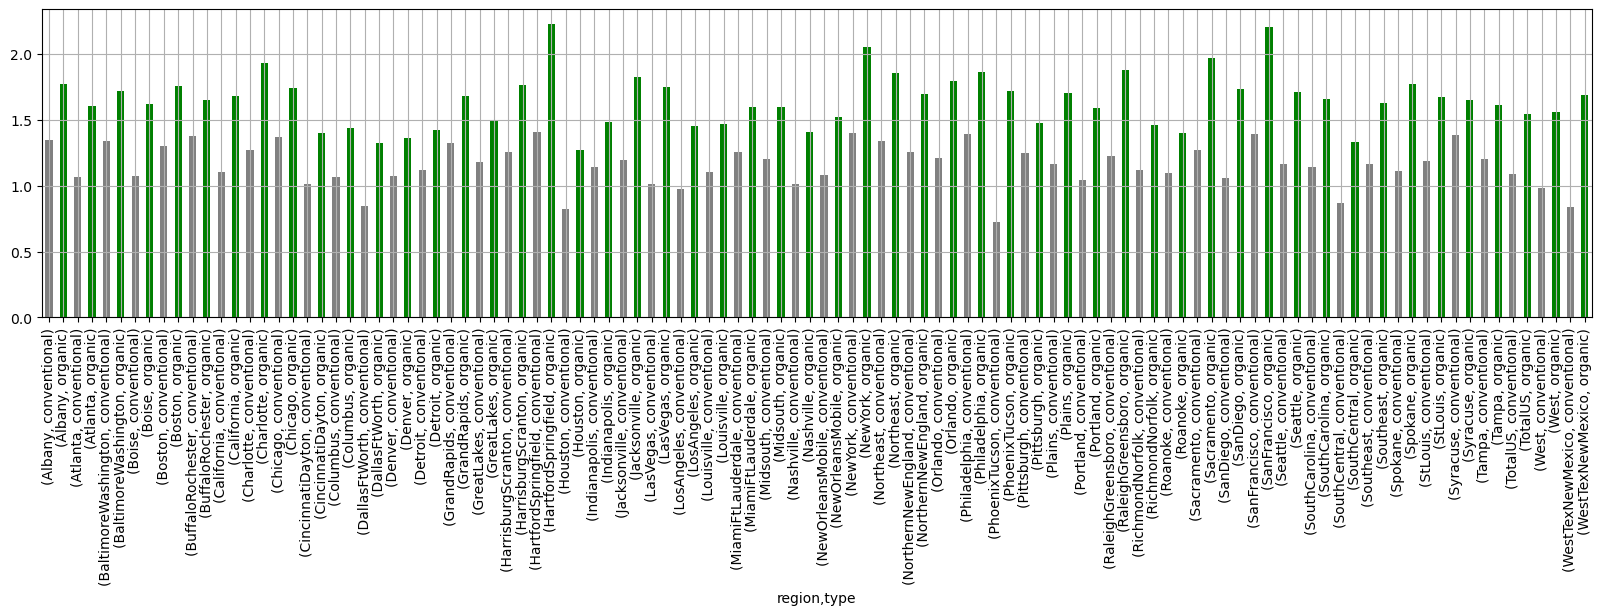

In [72]:
price_group = df_subset.groupby(['region', 'type'])['AveragePrice'].mean()#.nlargest(10)

fig, ax= plt.subplots(figsize=(20,4))
price_group.plot(kind='bar', ax=ax, color = ['gray', 'green'] )
# plt.ylim(0, 0.3*10**9)
plt.grid()

Observaciones:
* TODO: Aquest gràfic es espectacular, y ens permet veure que sempre són els alvocats orgànics els que costen més que la mitjana.

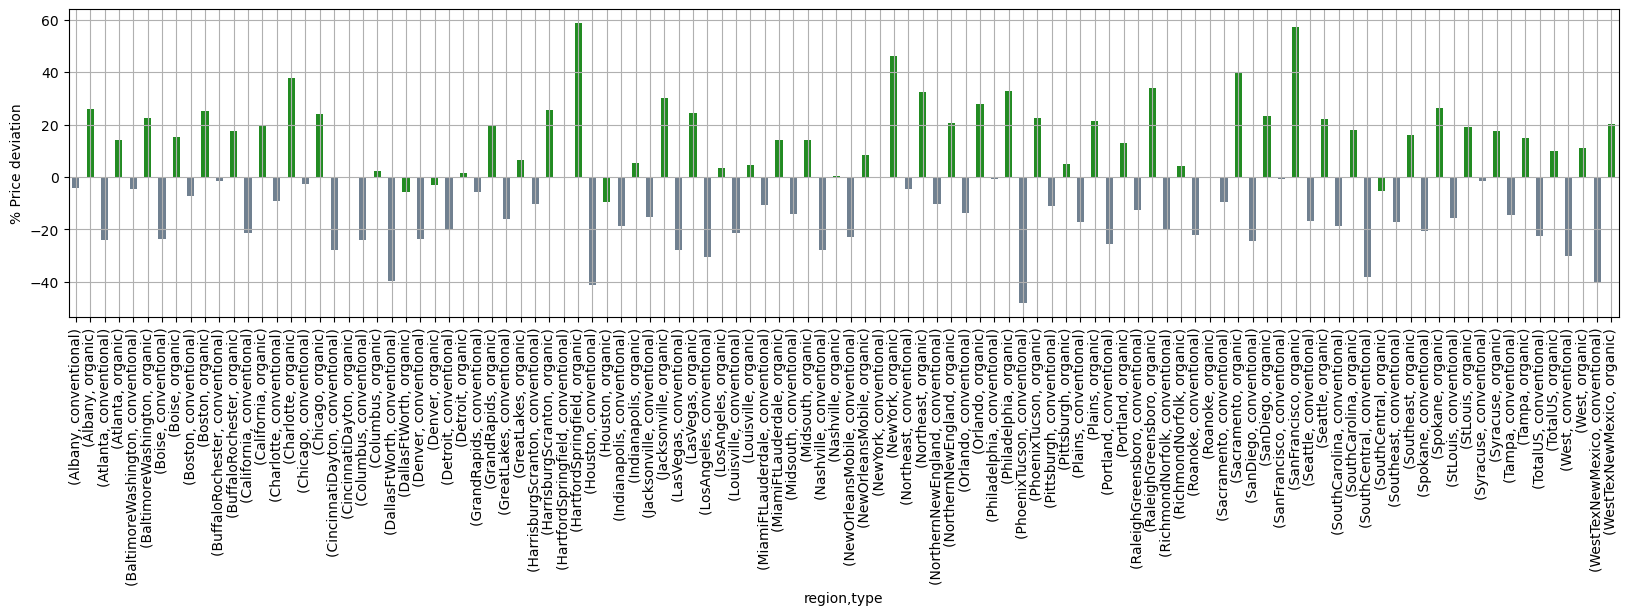

In [73]:
avocados_region_mean = df_subset.groupby(['region','type'])['AveragePrice'].mean()#.nlargest(6)

total_mean = df_subset['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation', color = ['slategray', 'forestgreen'])
plt.grid()

##### TODO: Convencional vs Organic
Observaciones:
* TODO: 
  * Si mirem la proporcio, en general es manté constant. No hi ha ningun interes per a tornar a ho natural a les gran ciutats o extensions.
  * Si acas hi ha més divergencia en extensions menors.

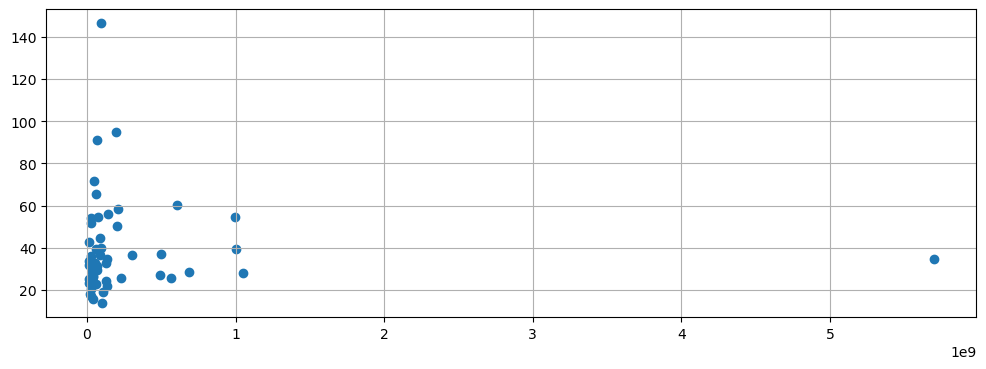

In [74]:
grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()
unstacked_type= grouped.unstack()
unstacked_type['Proportion'] = unstacked_type['conventional']/unstacked_type['organic']

fig, ax= plt.subplots(figsize=(12,4))
x_values= unstacked_type['conventional']
y_values= unstacked_type['Proportion']
ax.scatter(x=x_values, y= y_values )
# plt.ylim(0, 0.3*10**9)
plt.grid()

##### Ventas en el tiempo y separación entre convencional / orgánico

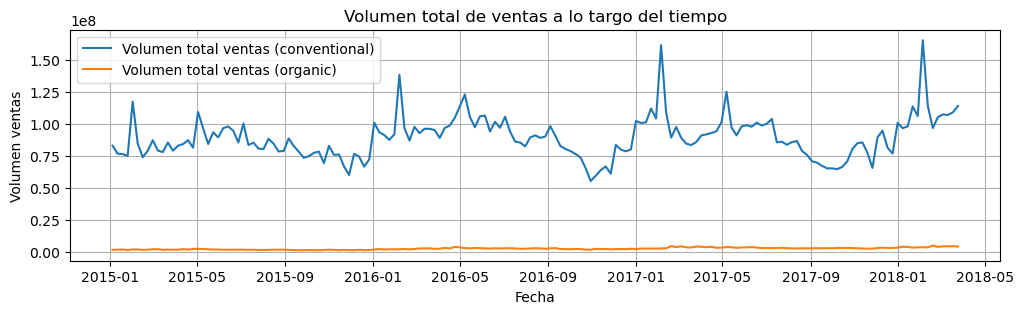

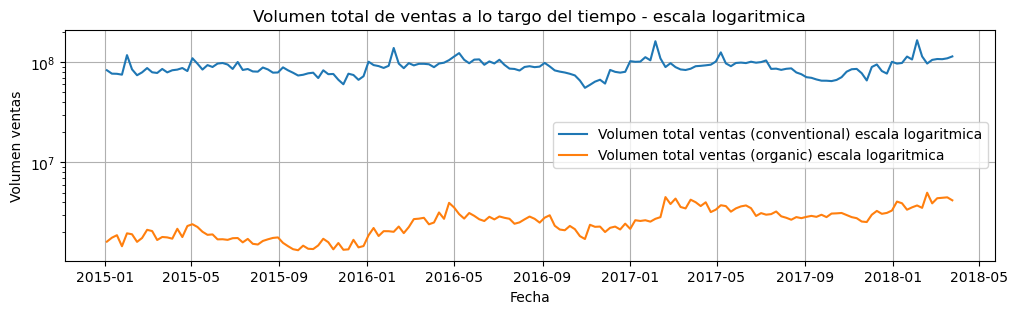

In [75]:
df_date_volume = df_cp[['Date', 'Total Volume']]
#df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
#df_date_volume
df_grouped_conventional = df_date_volume[df_cp['type'] =='conventional'].groupby('Date').sum('Total Volume')
df_grouped_organic = df_date_volume[df_cp['type'] =='organic'].groupby('Date').sum('Total Volume')

# Graficar
plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo')
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.show()

plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo - escala logaritmica')
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.show()

##### Análisis de Cambios en Precios Anuales:

year
2015    1.375590
2016    1.338640
2017    1.515128
2018    1.347531
Name: AveragePrice, dtype: float64

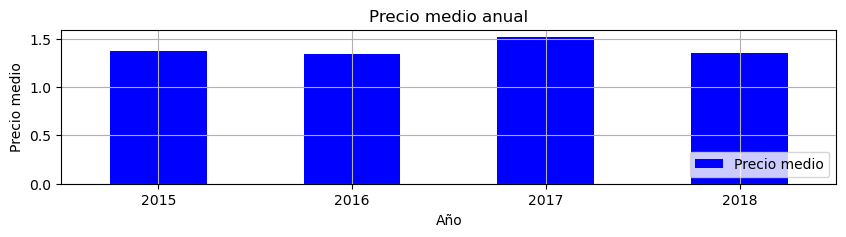

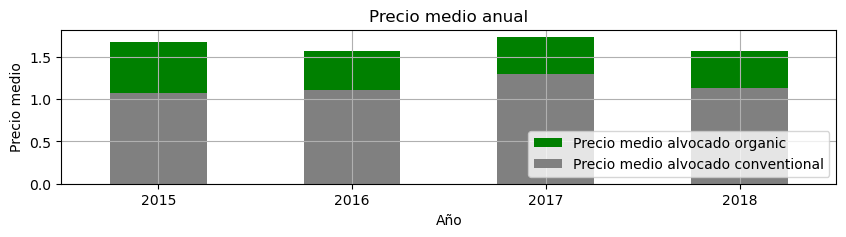

In [76]:
df_year_price = df_cp.groupby('year')['AveragePrice'].mean()
df_year_price_conventional = df_cp[df_cp['type'] =='conventional'].groupby('year')['AveragePrice'].mean()
df_year_price_organic = df_cp[df_cp['type'] =='organic'].groupby('year')['AveragePrice'].mean()
display(df_year_price)

# Graficar
plt.figure(figsize=(10, 2)) 
df_year_price.plot.bar(label ='Precio medio', color ='blue', alpha=1) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual')
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(10, 2)) 
df_year_price_organic.plot.bar(label ='Precio medio alvocado organic', color ='green') # x='aaa??',y='bbb??',
df_year_price_conventional.plot.bar(label ='Precio medio alvocado conventional', color ='grey') # x='aaa??',y='bbb??',
#df_year_price.plot.bar(label ='Precio medio', color ='blue', alpha=0.2) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual')
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()

##### Representación de ventas totales sobre precio promedio ( por regiones o no )

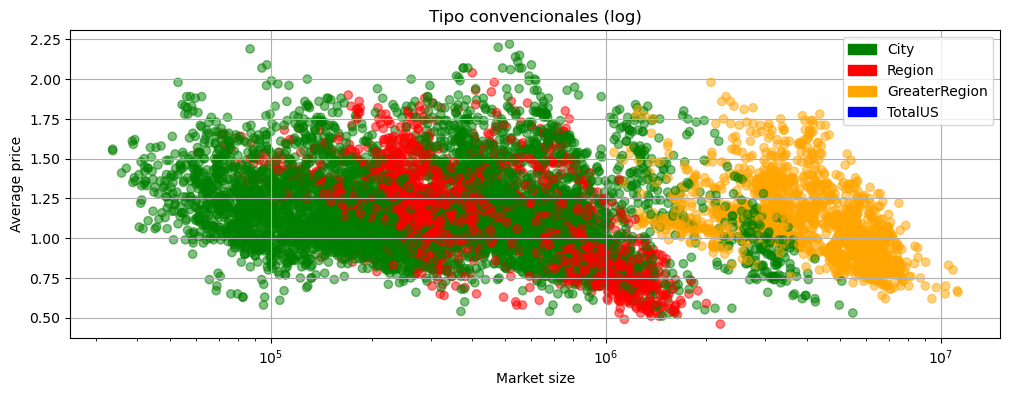

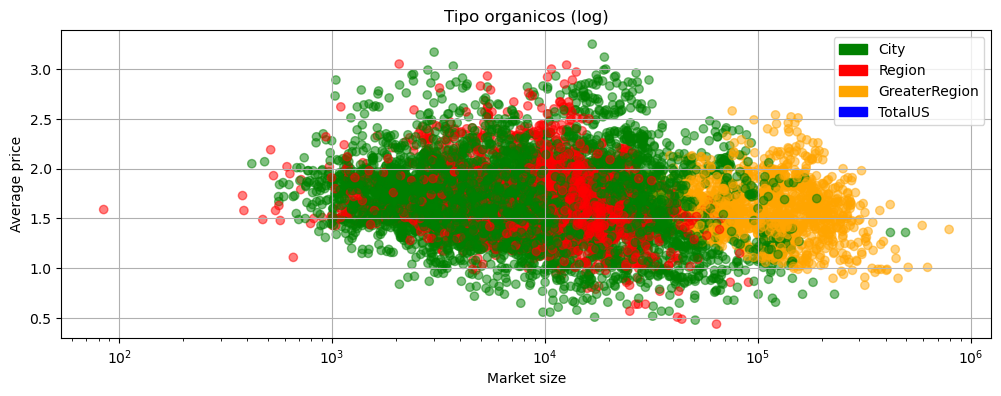

In [77]:
classification_colors = {'City':'green' ,'Region':'red' ,'GreaterRegion':'orange', 'TotalUS': 'blue'}

#df_subset = av.df("df_city_region") 
df_subset = df_cp[df_cp['region']!= 'TotalUS']

df_organic = df_subset[df_subset['type']=='organic']
df_convencionals = df_subset[df_subset['type']=='conventional']

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_convencionals['Total Volume']
y_values = df_convencionals['AveragePrice']
c_values= list(df_convencionals['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo convencionales (log)')
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_organic['Total Volume']
y_values = df_organic['AveragePrice']
c_values= list(df_organic['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo organicos (log)')
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()

In [78]:
# df_convencionals
index_df = df_cp_cleaned.copy()
#['West', 'California', 'SouthCentral', 'Northeast', 'Southeast']
great_reg_col = {'California' : 'red', 'West':'Orange', 'SouthCentral':'green', 'Northeast':'SkyBlue', 'Southeast':'DarkBlue'}

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
df_regions = df_convencionals[df_convencionals['region'].isin(region_largest)]

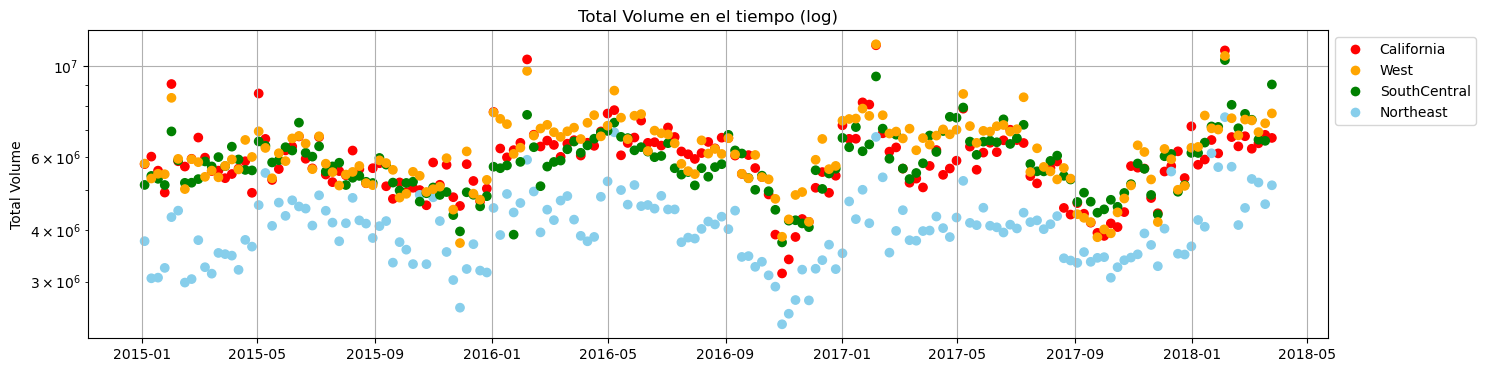

In [79]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['Total Volume']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
plt.yscale('log')
plt.title('Total Volume en el tiempo (log)')
plt.ylabel('Total Volume')
#plt.xlabel('Date')
#plt.legend() #loc='lower right')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

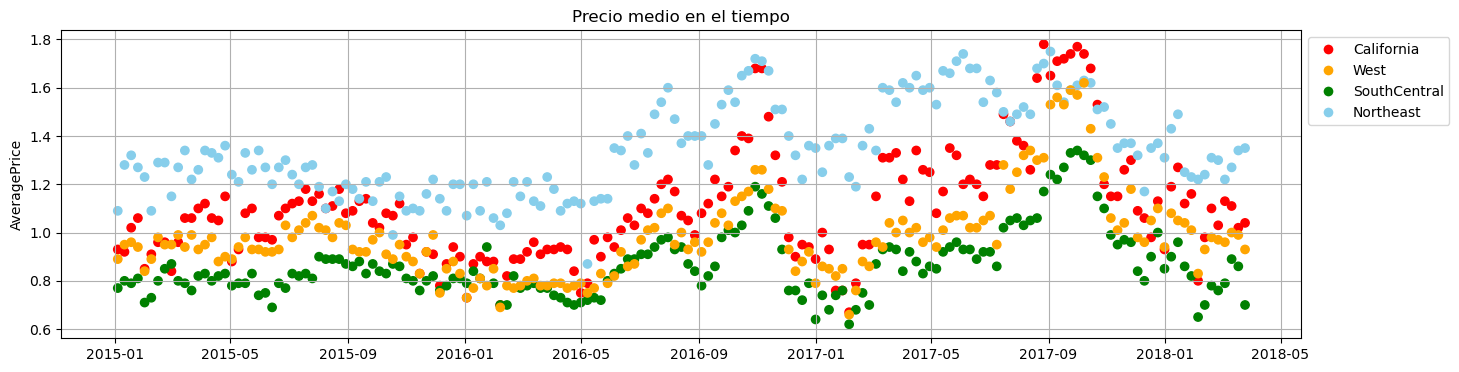

In [80]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['AveragePrice']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
#plt.yscale('log')
plt.title('Precio medio en el tiempo')
plt.ylabel('AveragePrice')
#plt.xlabel('Date')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

#### Subset alvocados convencionals
* Aqui tendriamos que incluir una idea de si todas las regiones hacen un número similar total de pedidos
* Claramente hay sitios donde los aguacates son más baratos, miremos si tiene que ver con otras características

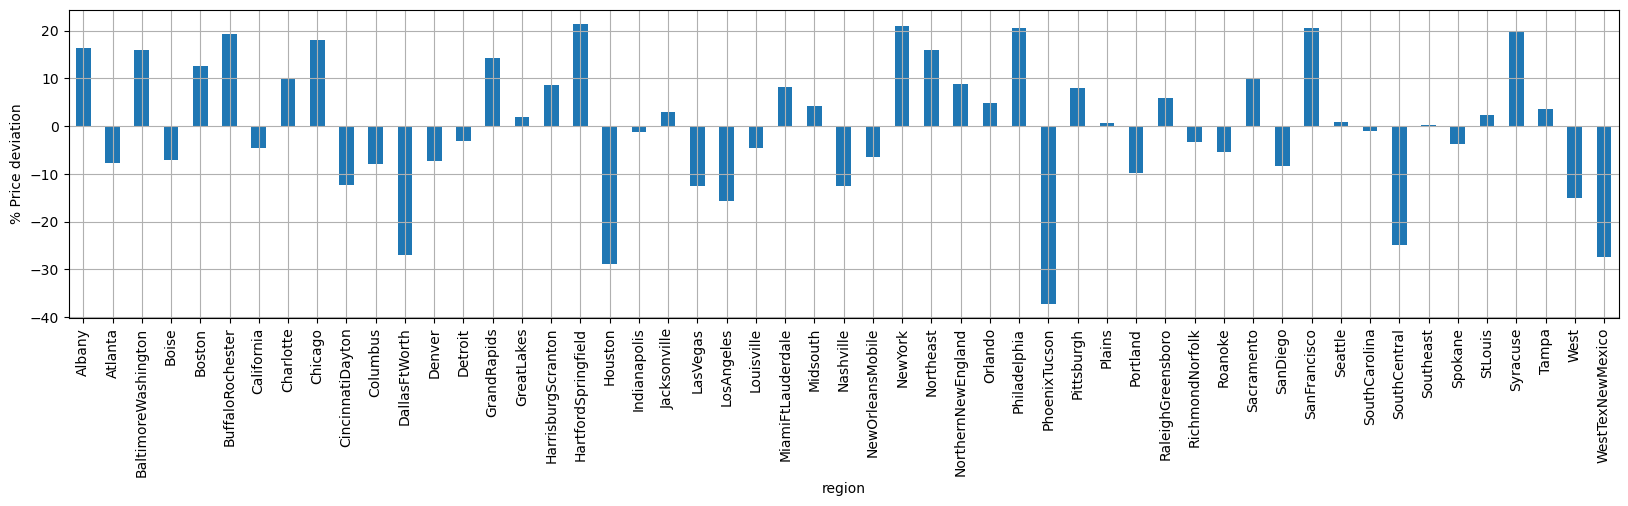

In [81]:
df_subset = df_cp[df_cp['region']!= 'TotalUS']
df_convencionals = df_subset[df_subset['type']=='conventional']
convencional_region_mean = df_convencionals.groupby('region')['AveragePrice'].mean()#.nlargest(6)
coloring=convencional_region_mean.index.map(av.region_classification).map(av.classification_colors)
total_mean = df_convencionals['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
avocados_relative_mean = ((convencional_region_mean - total_mean)*100/total_mean)
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation')#, color= coloring)#, color= convencional_region_mean.index.map(classification_colors))
plt.grid()

#### Majors mercats el preu mig tendeix a abaratirse
* Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
* Aqui estem prenent cada regio com equivalentment valida
* cambiar el 2018 no parece afectar los resultados

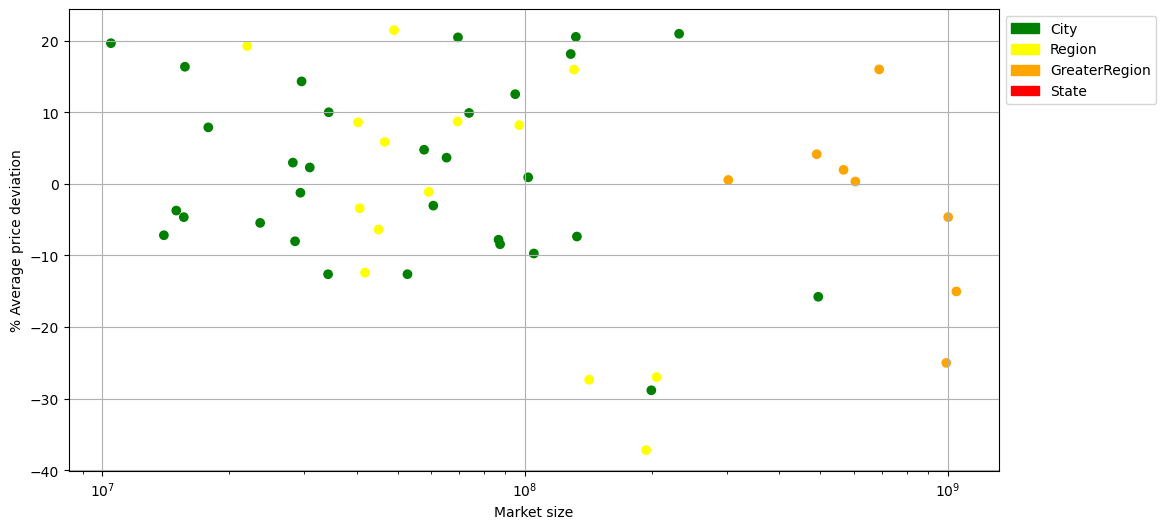

In [82]:
convencional_region_mean_total = df_convencionals.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
convencional_region_mean_total['region_class'] = convencional_region_mean_total.index.map(av.region_classification)

x_values = convencional_region_mean_total['Total Volume']
total_mean = convencional_region_mean_total['AveragePrice'].mean()
y_values = (convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= list(convencional_region_mean_total['region_class'].map(av.classification_colors))

fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values)
plt.xscale('log')
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in av.classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

### ANALISIS

#### Separar alvocats convencionals i alvocats orgànics

#### Impacto del precio en las ventas

#### Estacionalidad por región

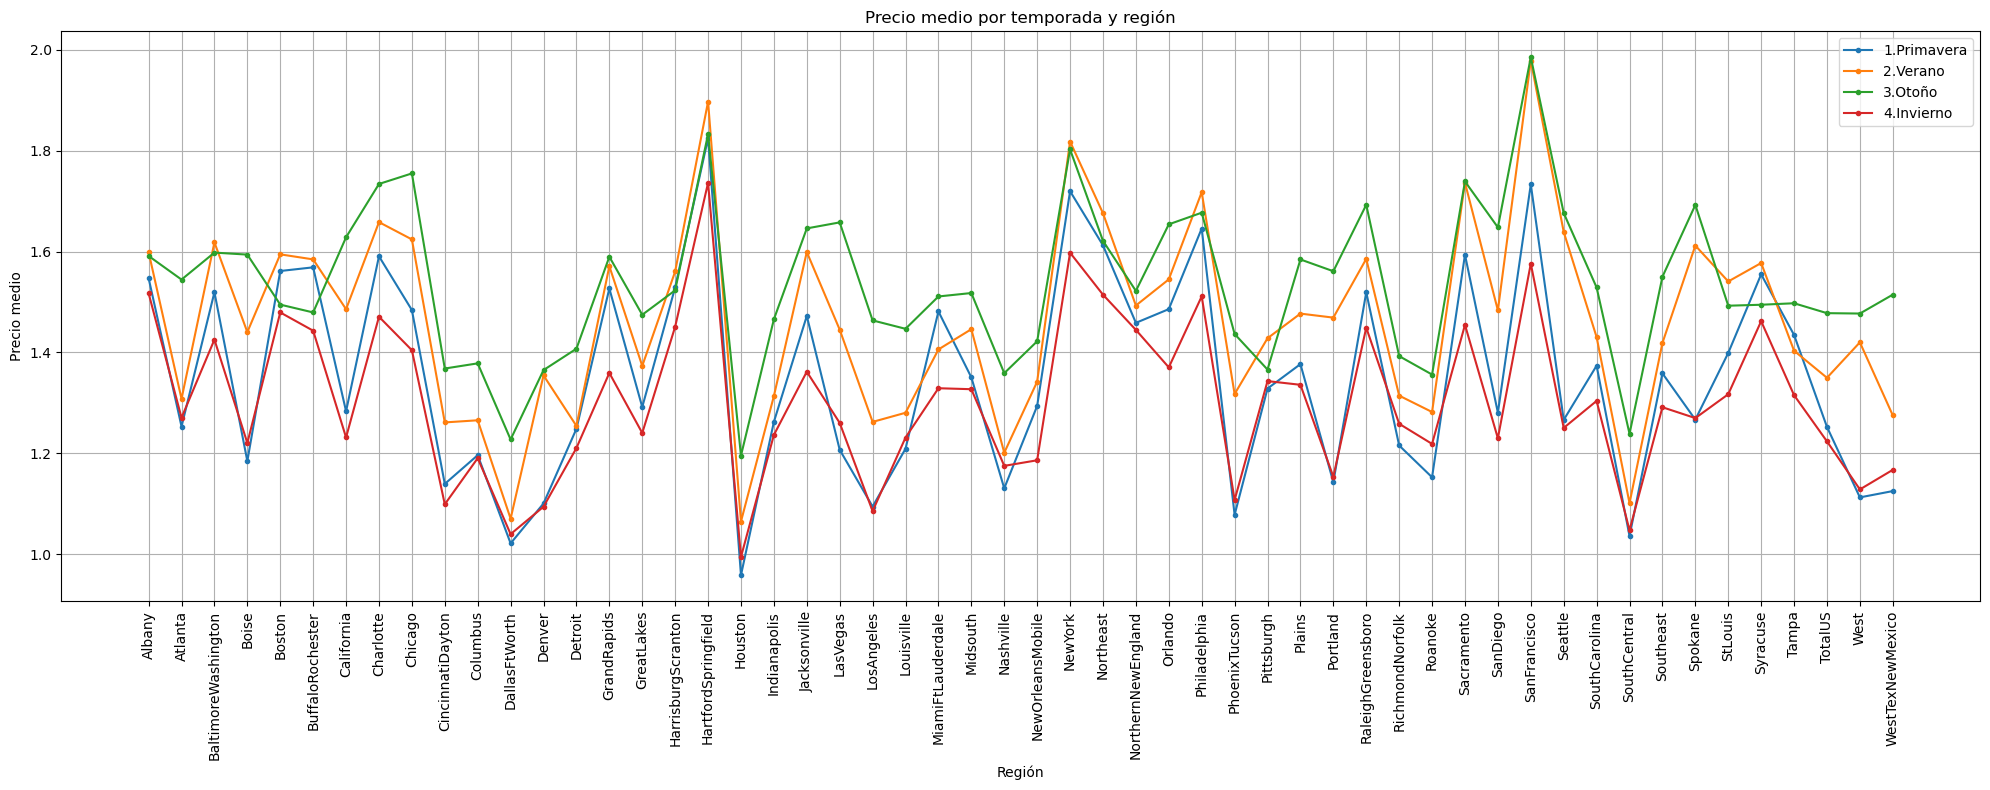

In [83]:
get_season = av.get_season()

df_date_price_volume = df_cp[['Date', 'region', 'AveragePrice', 'Total Volume']]
df_date_price_volume = df_date_price_volume.reset_index()
df_date_price_volume['Season'] = df_date_price_volume['Date'].apply(get_season)
# df_date_price_volume

df_grouped_mean = df_date_price_volume.groupby(['Season','region'])['AveragePrice'].mean()
df_grouped_mean = df_grouped_mean.reset_index()

seasons = df_grouped_mean['Season'].unique()
plt.figure(figsize=(20, 8)) 
for season in seasons:
    df_season = df_grouped_mean[df_grouped_mean['Season'] == season]
    plt.plot(df_season['region'], df_season['AveragePrice'], marker='.', label=season)
plt.title('Precio medio por temporada y región')
plt.xlabel('Región')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#df_grouped_mean

#### Correlacion de les "grans regions" i regions amb volum total US
* TODO: IMPORTANT VOLUM VENTAS GREATERREGIONS == TOTALUS

In [84]:
df_great_regions = df_cp[(df_cp['region_class']=='Region') | (df_cp['region_class']=='City')]
df_USA = df_cp[df_cp['region']=='TotalUS']
print((df_great_regions['Total Volume'].sum() - df_USA['Total Volume'].sum())*100/df_USA['Total Volume'].sum() )

-35.309628185172656


<AxesSubplot: title={'center': 'Market size'}, ylabel='Total Volume'>

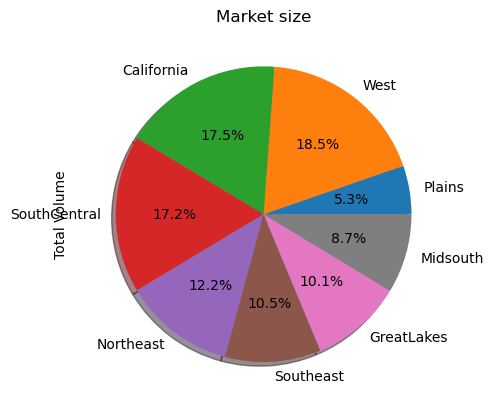

In [85]:
index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='City']

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(3).index)
# region_largest.pop('TotalUS')

df_greatest_pie = df_cp.groupby('region')['Total Volume'].sum().nlargest(8)   #df_cp[df_cp['region'].isin(region_largest)]
df_greatest_pie.loc['TotalUS'] = 2*df_greatest_pie.loc['TotalUS'] - df_greatest_pie.loc[:].sum()
df_greatest_pie.rename( index={'TotalUS':'Plains'}, inplace=True)
df_greatest_pie.plot.pie(title="Market size", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)
#plt.legend(loc='best'); plt.grid(True) # figsize=(12,6)

#### Correlacion de volum total de les ciutats amb volum total US

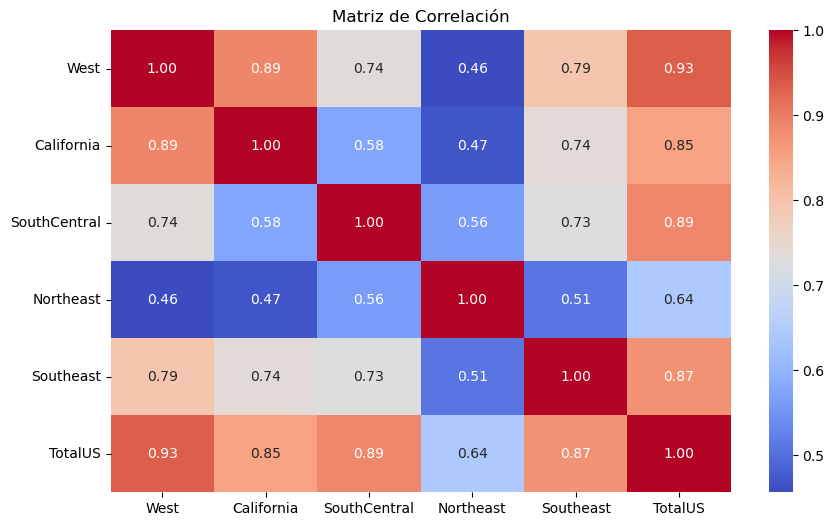

Variables altamente correlacionadas con otras: ['West', 'TotalUS']


In [86]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']
dictionary_to_regions={}

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
region_largest.append('TotalUS')

for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')

    dictionary_to_regions[region] = list(prova_temp['Total Bags'])

df_corr = pd.DataFrame(dictionary_to_regions)
# display(df_corr)
corr_matrix = df_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.9
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

#### Elasticidad

#### Analisis por cohortes

##### 1. Cohortes Basadas en Precios Promedios Trimestrales:

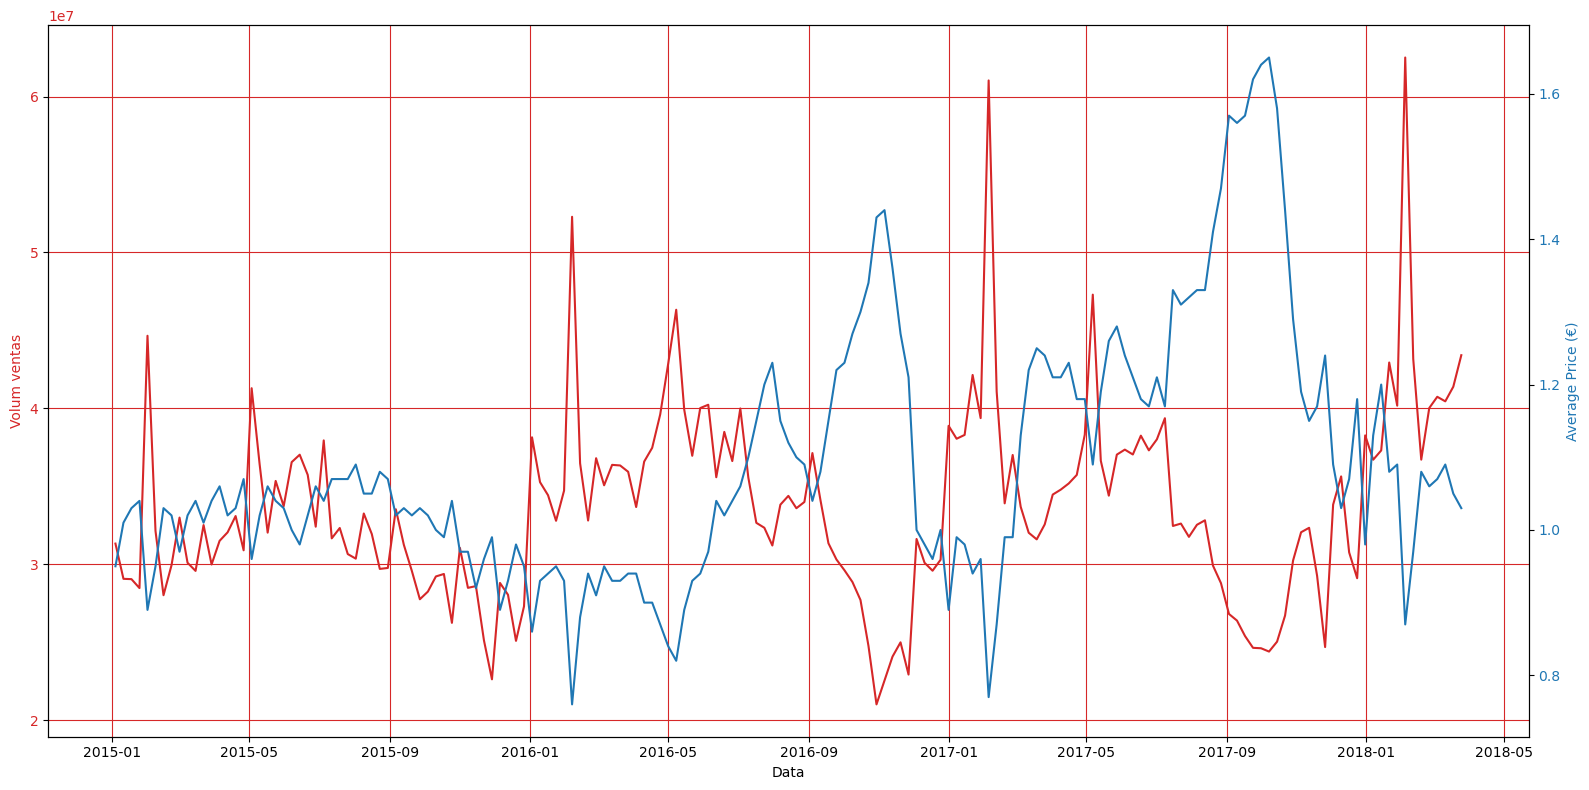

In [87]:
df_USA = df_cp_cleaned[df_cp_cleaned['region']=='TotalUS'].copy()
df_USA = df_USA[df_USA['type']=='conventional']#.copy()
df_media = df_USA.groupby([pd.Grouper(key='Date', freq='QS')]).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()
df_media = df_USA.groupby(['Date']).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()

df_media['Date offset'] = df_media['Date'] - pd.DateOffset(months=5)

# display(df_temp)
#%%
fig, ax1 = plt.subplots(figsize=(16,8))
#plt.title('Estudio economico')
color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Volum ventas', color=color)
ax1.plot(df_media['Date'], df_media['Total Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Price (€)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_media['Date'], df_media['AveragePrice'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.ylim(0, 5)
#ax2.grid(color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(rotation = 90)
plt.show()

##### 2. Cohortes por Región y Fecha:

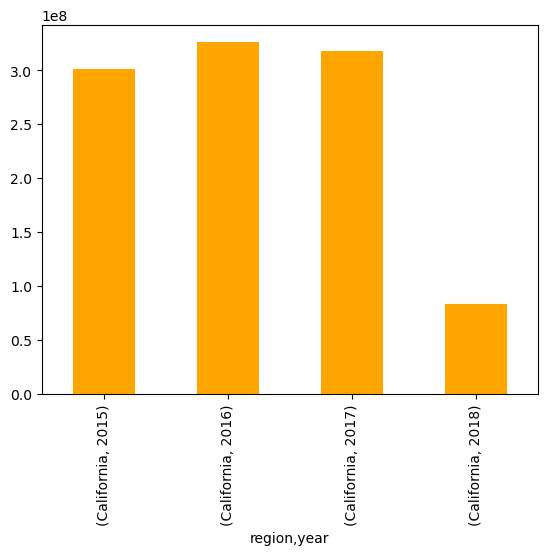

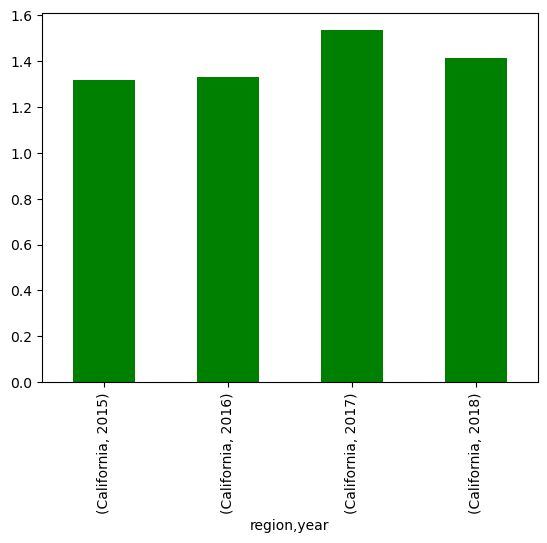

In [88]:
df_no_USA = df_cp_cleaned[df_cp_cleaned['region']=='California']
df_media = df_no_USA.groupby(['region', 'year']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.reset_index()

df_media['Total Volume'].plot(kind='bar', label = 'Total Volume', color= 'orange')
plt.show()

df_media['AveragePrice'].plot(kind='bar', label = 'Average Price', color= 'green')
plt.show()

##### 3. Análisis de Cohortes en Función del Tipo de Bolsa:

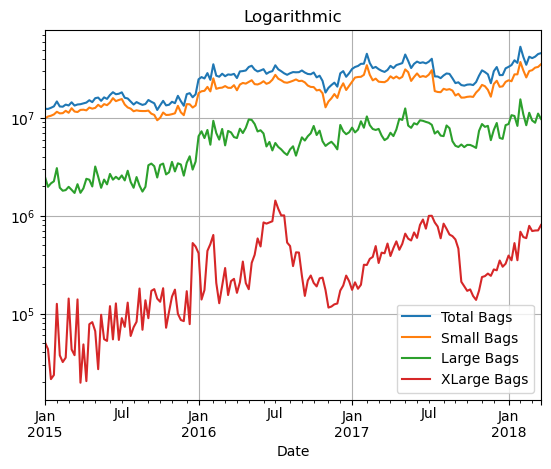

In [89]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

# df_bag_temp = df_cp_cleaned[df_cp_cleaned['region']=='Philadelphia'].copy()
df_bag_temp = df_cp_cleaned.copy()
df_bag_temp= df_cp_cleaned.groupby('Date')['Total Bags'].sum()

fig, ax= plt.subplots()
for title_bag in columnas_bags: 
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

plt.yscale('log')
plt.title('Logarithmic')
plt.grid()
plt.legend()
plt.show()

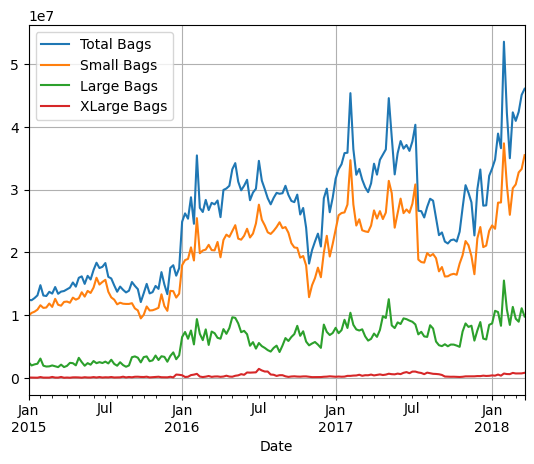

In [90]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

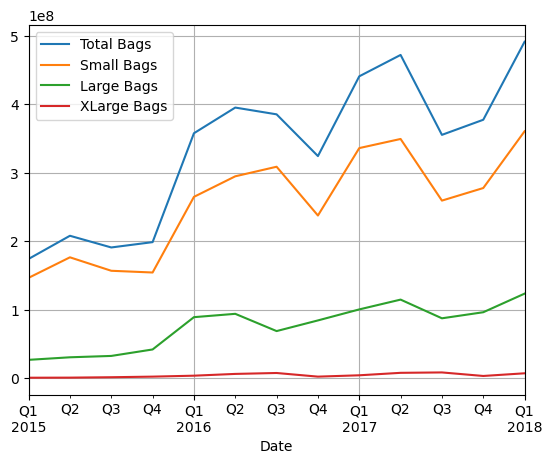

In [91]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby([pd.Grouper(key='Date', freq='QS')])[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

##### 4. Cohortes de Clientes Basadas en Ventas:

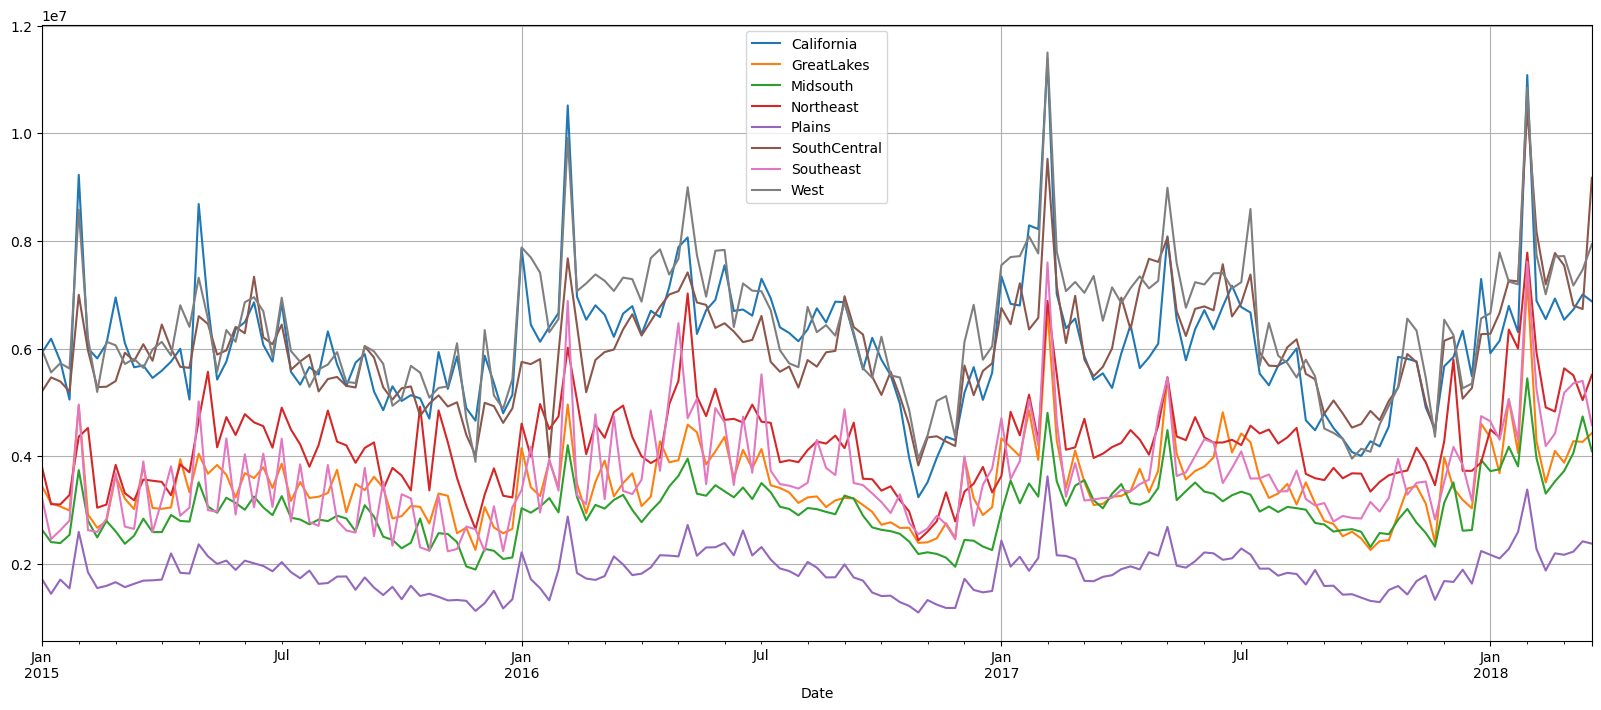

In [92]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

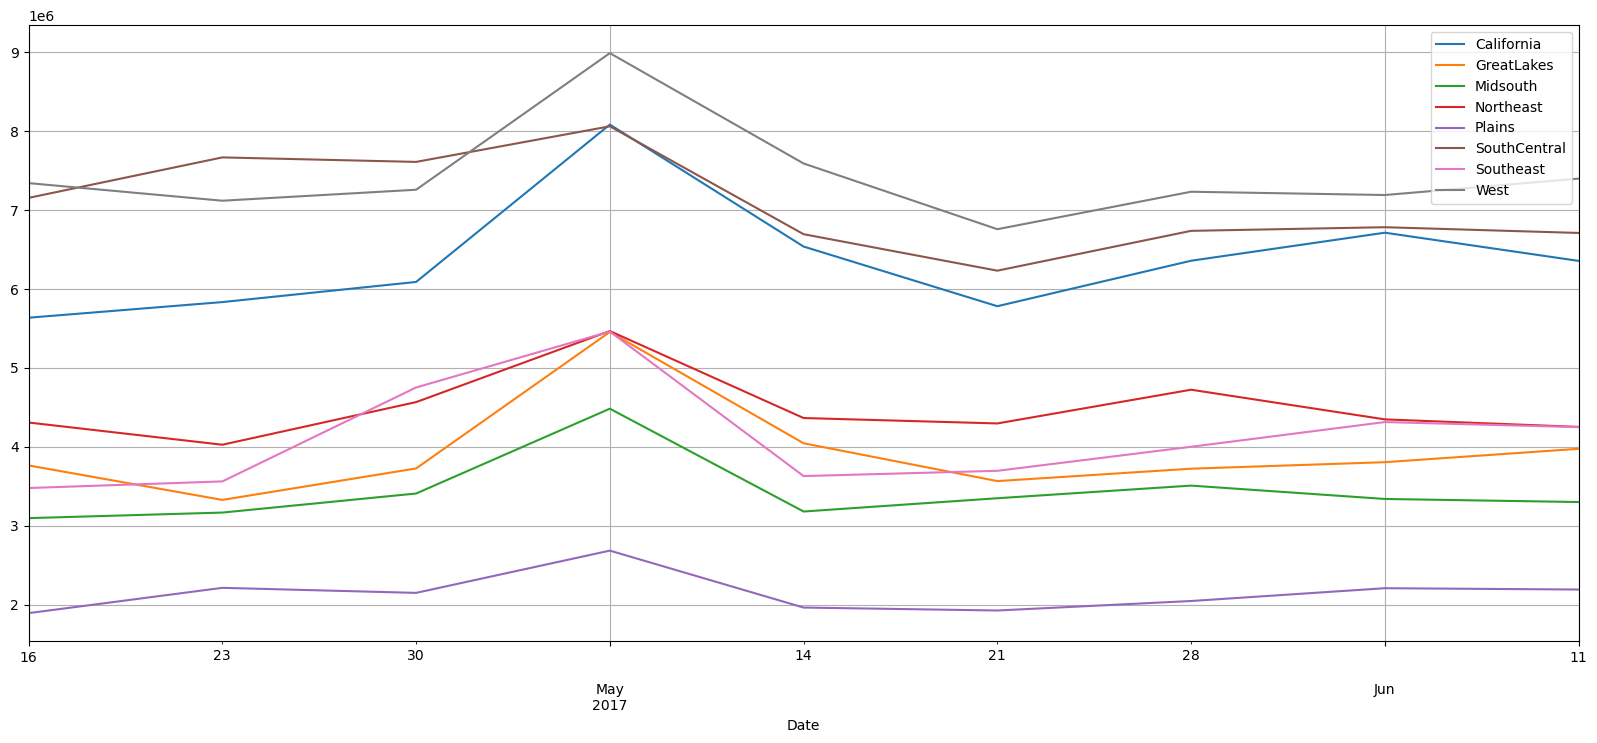

In [93]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'2017-06-15')&(df_cleaned_great_regions['Date']>'2017-04-15')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

##### 5. Evaluación de Retención de Ventas por Cohorte:

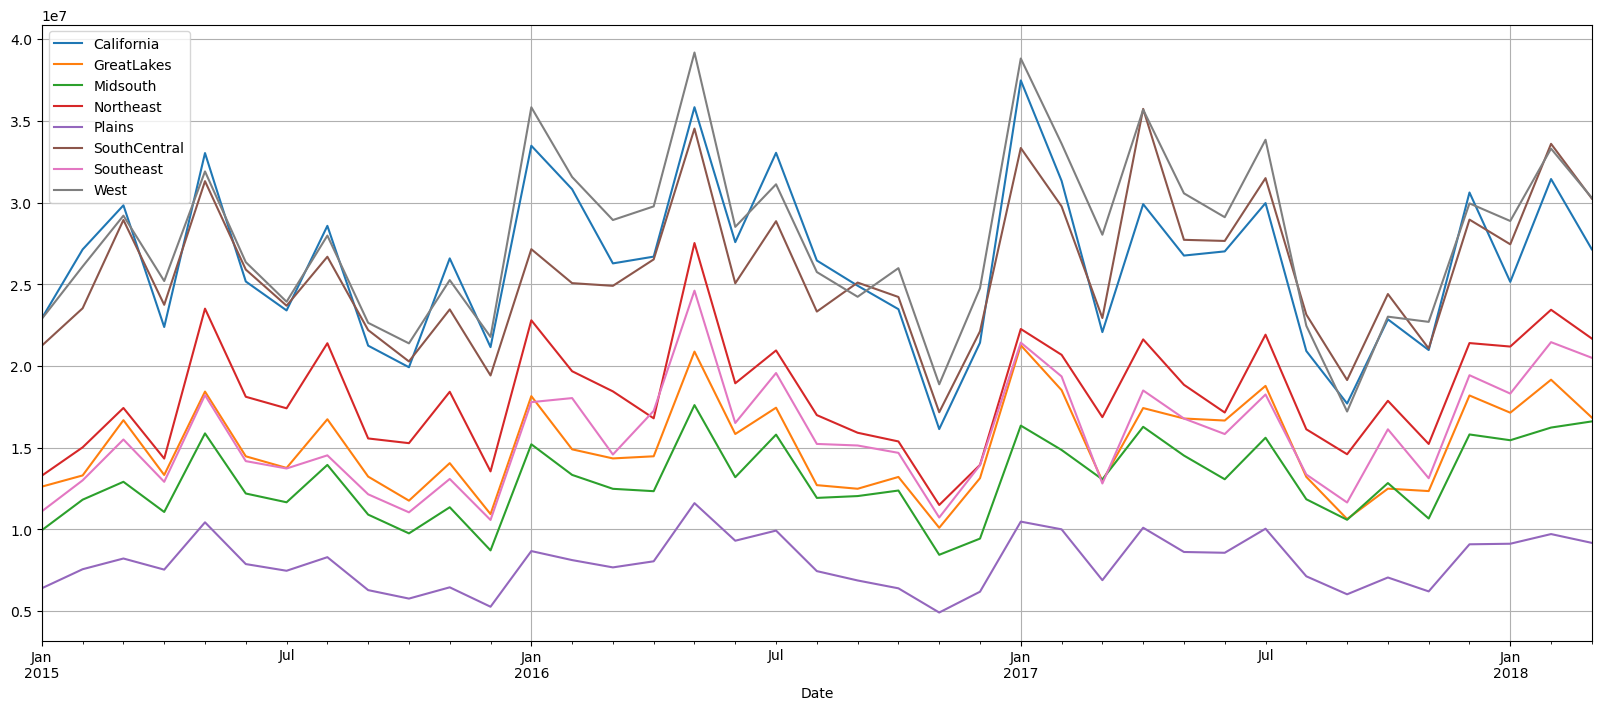

In [94]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby([pd.Grouper(key='Date', freq='MS')])['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

#### Matriz de correlaciones de todas las variables según  apartado 5.6. En especial, precio medio y relación con diferentes calibres.

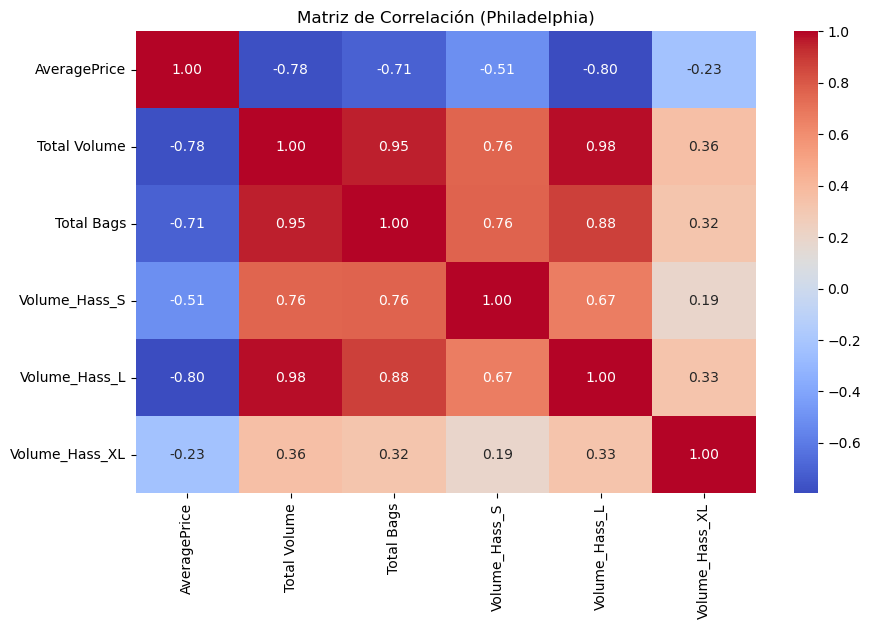

Variables altamente correlacionadas con otras: ['Total Volume', 'Total Bags', 'Volume_Hass_L']


In [95]:
df_corr_gen= df_cp.copy()
df_corr_gen = df_corr_gen[df_corr_gen['region']=='Philadelphia']
# df_corr_gen = df_corr_gen[(df_corr_gen['region_class']== 'City') | (df_corr_gen['region_class']== 'Region')]

corr_df= df_corr_gen[['AveragePrice', 'Total Volume', 'Total Bags' ,'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (Philadelphia)')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

#### Dispersión entre variables claves según 5.2

In [96]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']
df_local= df_local[df_local['region']=='TotalUS']
df_local = df_local[df_local['AveragePrice']==1.0]
display(df_local)

index       Date  AveragePrice  Total Volume  Volume_Hass_S  \
11798  11798 2015-08-09           1.0      625259.0       170184.0   
11799  11799 2015-08-02           1.0      573873.0       164126.0   
11800  11800 2015-07-26           1.0      580826.0       169940.0   
11801  11801 2015-07-19           1.0      650389.0       159752.0   
11802  11802 2015-07-12           1.0      608845.0       178871.0   
11803  11803 2015-07-05           1.0      668233.0       205073.0   

       Volume_Hass_L  Volume_Hass_XL  Total Bags  Small Bags  Large Bags  \
11798       269330.0          6905.0    178838.0    126058.0     52779.0   
11799       263359.0          5115.0    141271.0     93120.0     48151.0   
11800       266249.0          4391.0    140244.0     71807.0     68436.0   
11801       317728.0          4758.0    168149.0     81667.0     86482.0   
11802       267353.0          5093.0    157526.0     80220.0     77305.0   
11803       304597.0          6251.0    152309.0     88261.0     64048.0   

       XLarge Bags     type  year   region region_class  Suma Volums  \
11798          0.0  organic  2015  TotalUS      TotalUS     446419.0   
11799          0.0  organic  2015  TotalUS      TotalUS     432600.0   
11800          0.0  organic  2015  TotalUS      TotalUS     440580.0   
11801          0.0  organic  2015  TotalUS      TotalUS     482238.0   
11802          0.0  organic  2015  TotalUS      TotalUS     451317.0   
11803          0.0  organic  2015  TotalUS      TotalUS     515921.0   

        Variacio  
11798  28.602547  
11799  24.617468  
11800  24.145958  
11801  25.853912  
11802  25.873252  
11803  22.793247

* TODO ?

In [97]:
# df_local = df_cp.copy()
# df_local= df_local[df_local['type']=='conventional']

# # df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
# df_local_USA=df_local[df_local['region_class']=='TotalUS']

# fig, ax= plt.subplots(figsize=(10,6))

# # sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
# sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
# plt.xscale('log')
# plt.grid()
# plt.title('Conventional')
# plt.figure()

<Figure size 640x480 with 0 Axes>

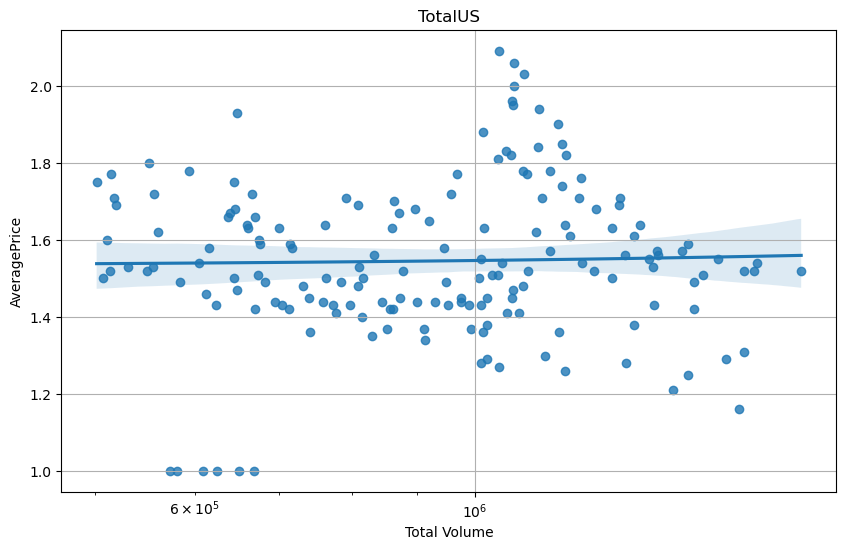

<Figure size 640x480 with 0 Axes>

In [98]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()

<Figure size 640x480 with 0 Axes>

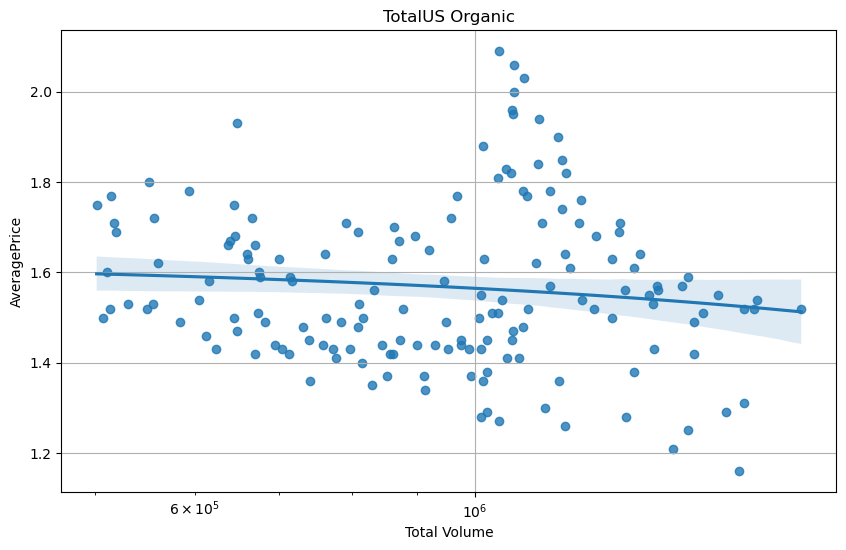

<Figure size 640x480 with 0 Axes>

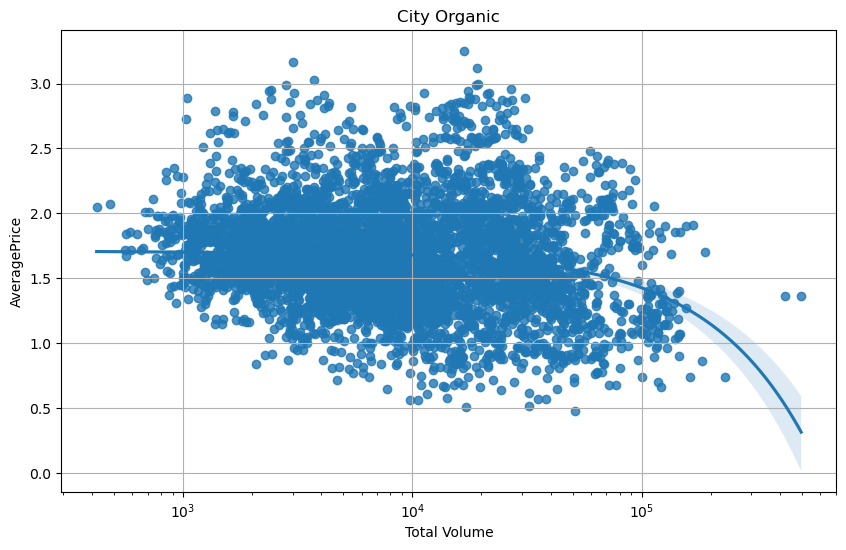

<Figure size 640x480 with 0 Axes>

In [99]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']
df_local_USA=df_local_USA[df_local_USA['AveragePrice']>1.1]

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS Organic')
plt.figure()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City Organic')
plt.grid()
plt.figure()

<Figure size 640x480 with 0 Axes>

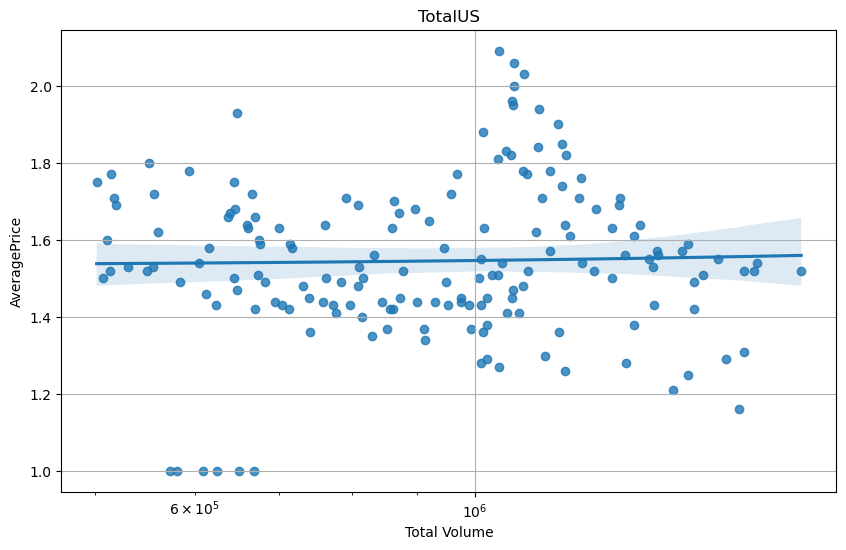

<Figure size 640x480 with 0 Axes>

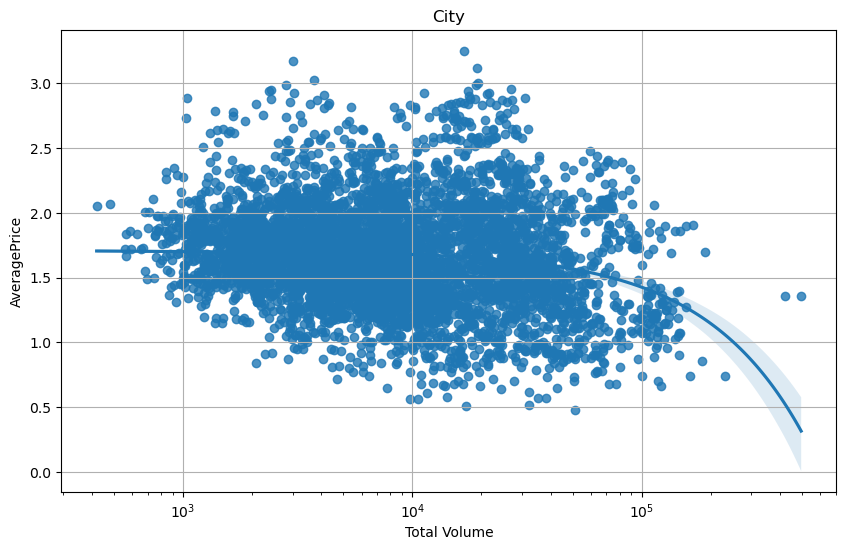

<Figure size 640x480 with 0 Axes>

In [100]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City')
plt.grid()
plt.figure()

 ### TODO

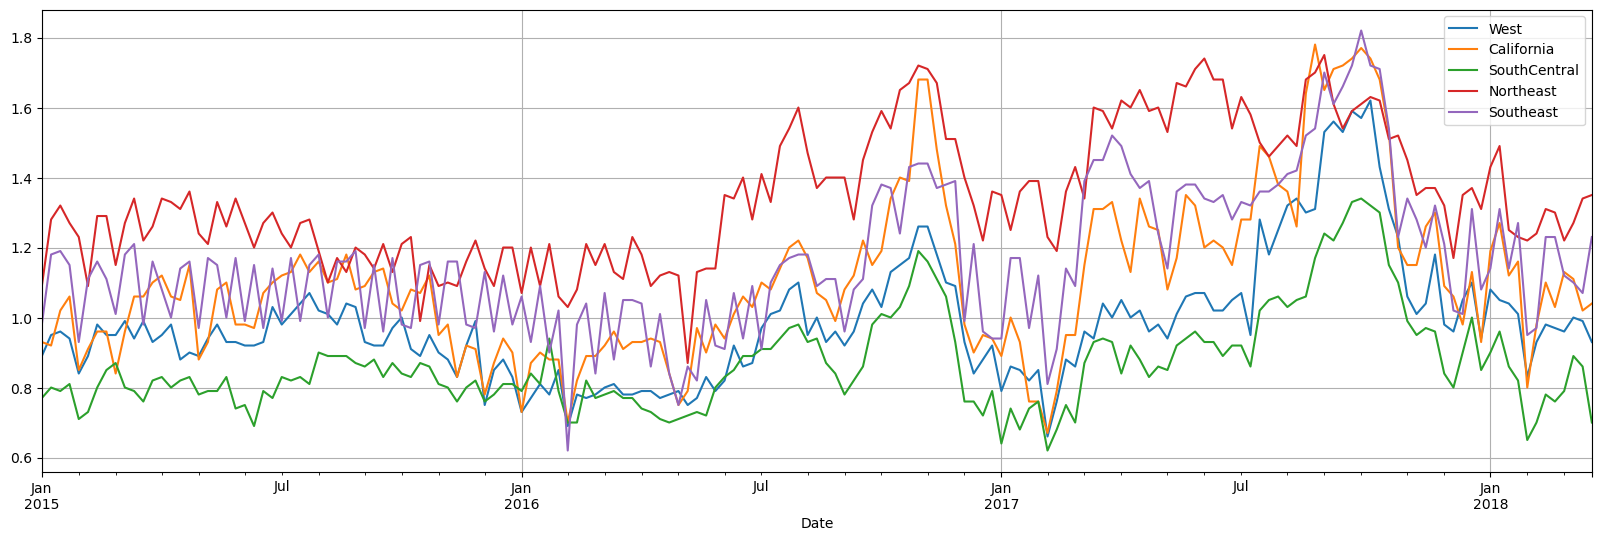

In [101]:
#df_cp_cleaned = av.df("df_cleaned")
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

#great_dates= df_cp_cleaned.copy()
#great_dates= great_dates[great_dates['type']=='conventional']

index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='GreaterRegion']

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
#region_largest#.append('TotalUS')
fig, ax= plt.subplots(figsize=(20,6))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'AveragePrice', ax=ax, label= region)

plt.grid()
plt.show()

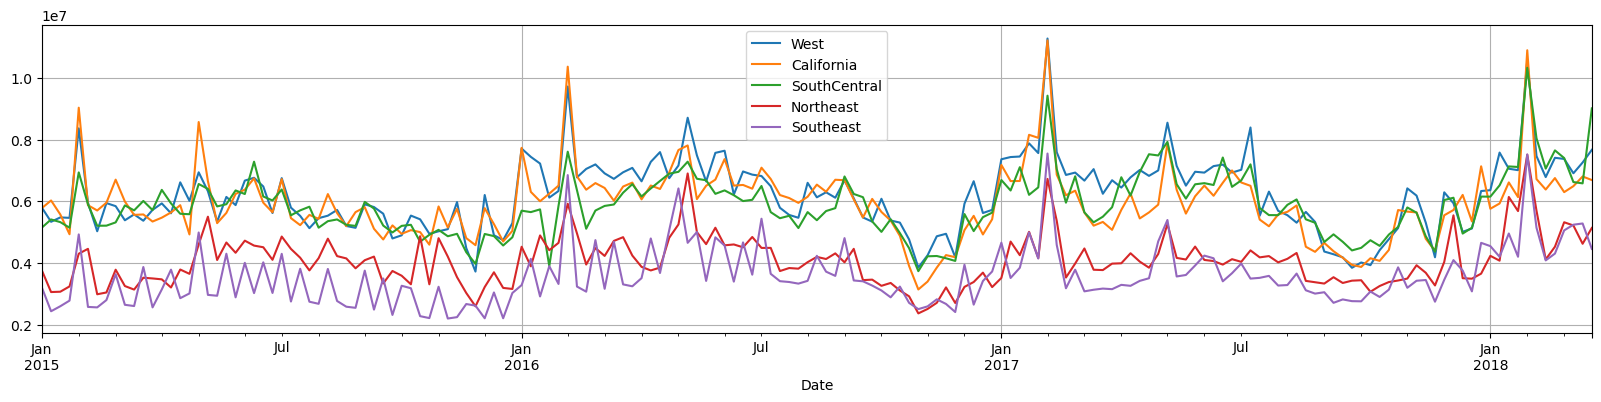

In [102]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
# region_largest.append('TotalUS')

fig, ax= plt.subplots(figsize=(20,4))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'Total Volume', ax=ax, label= region)
plt.legend(loc='best'); plt.grid(True)
plt.show()

<AxesSubplot: xlabel='region'>

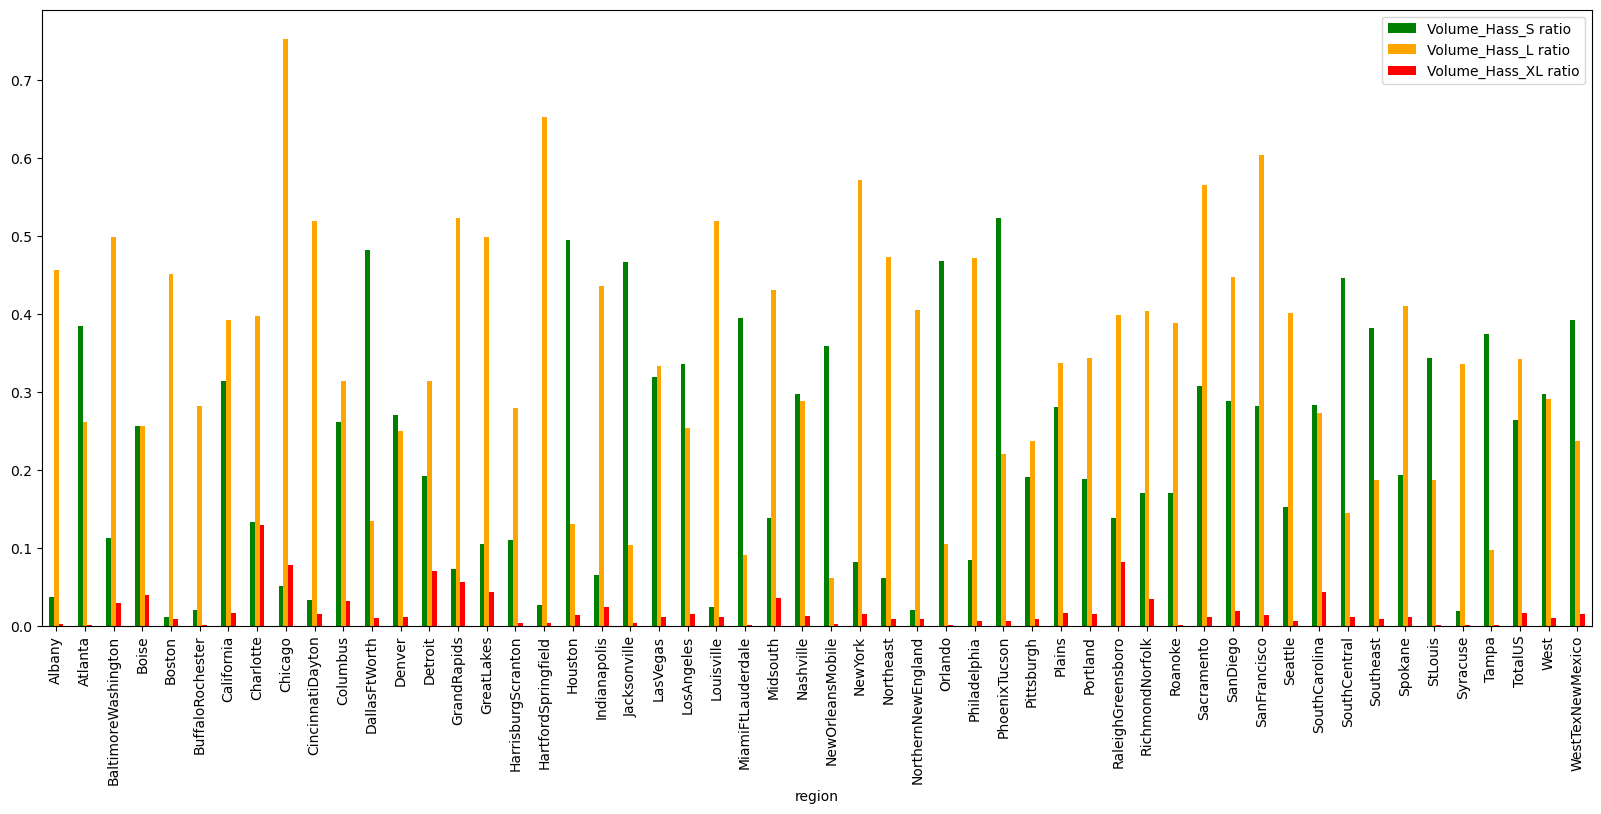

In [103]:
df_avocado_size = df_cp.copy()
df_avocado_size['Volume_Hass_S ratio'] = df_avocado_size['Volume_Hass_S'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_L ratio'] = df_avocado_size['Volume_Hass_L'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_XL ratio'] = df_avocado_size['Volume_Hass_XL'] / df_avocado_size['Total Volume']

fig, ax= plt.subplots(figsize=(20,8))
ratio_bag=df_avocado_size.groupby('region')[['Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )

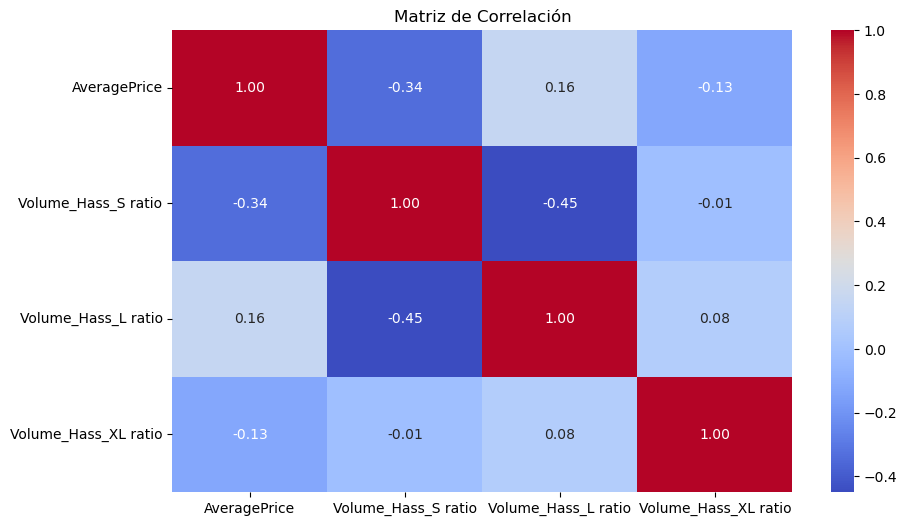

Variables altamente correlacionadas con otras: []


In [104]:
corr_df= df_avocado_size[['AveragePrice', 'Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

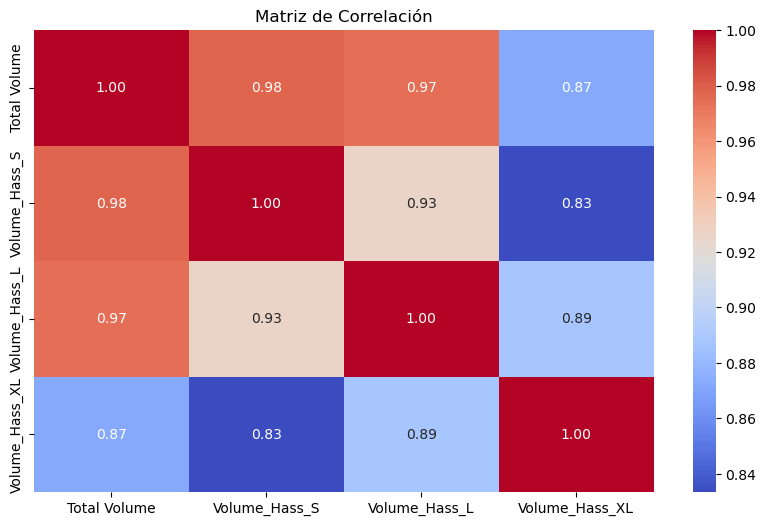

Variables altamente correlacionadas con otras: ['Total Volume', 'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']


In [105]:
corr_df= df_cp_cleaned[['Total Volume', 'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

#### TODO

In [106]:
#df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S' ]+ df_cp_cleaned['Volume_Hass_L']+ df_cp_cleaned['Volume_Hass_XL' ]
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums'])*100/df_cp_cleaned['Total Volume']
smallest_regions= df_cp_cleaned[df_cp_cleaned['region'].isin(region_largest) ]
small_group = df_cp_cleaned.groupby('region')['Variacio'].mean().sort_values()
small_group

region
SanFrancisco            9.955330
Sacramento             11.691686
Chicago                11.763706
SanDiego               24.562791
PhoenixTucson          25.091574
California             27.893113
HartfordSpringfield    31.802313
NewYork                33.026166
LasVegas               33.643763
Charlotte              34.138870
GrandRapids            34.893758
GreatLakes             35.297427
Atlanta                35.354104
WestTexNewMexico       35.650211
BaltimoreWashington    35.874110
Houston                36.019133
Plains                 36.695516
DallasFtWorth          37.400859
TotalUS                37.831299
RaleighGreensboro      38.106545
Spokane                38.631778
RichmondNorfolk        39.126347
Columbus               39.384025
LosAngeles             39.535156
Midsouth               39.536758
SouthCentral           39.728916
West                   40.108429
SouthCarolina          40.156343
Nashville              40.208491
Southeast              42.267471
Det

In [107]:
grouper = df_cp_cleaned.groupby('region')['Total Volume'].sum().nlargest(10).index

<AxesSubplot: >

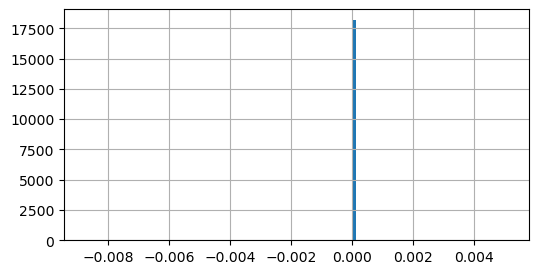

In [108]:
bags_df = df_cp_cleaned.copy()
bags_df['Suma Bags'] = bags_df['Small Bags']+ bags_df['Large Bags']+ bags_df['XLarge Bags']
bags_df['Variacio Bags'] = (bags_df['Total Bags'] - bags_df['Suma Bags'])*100/bags_df['Total Bags']
fig, ax= plt.subplots(figsize=(6,3))
bags_df['Variacio Bags'].hist(bins=100)

In [109]:
df_cp.head()
df_cp.info()
df_cp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           18249 non-null  int64         
 1   Date            18249 non-null  datetime64[ns]
 2   AveragePrice    18249 non-null  float64       
 3   Total Volume    18249 non-null  float64       
 4   Volume_Hass_S   18249 non-null  float64       
 5   Volume_Hass_L   18249 non-null  float64       
 6   Volume_Hass_XL  18249 non-null  float64       
 7   Total Bags      18249 non-null  float64       
 8   Small Bags      18249 non-null  float64       
 9   Large Bags      18249 non-null  float64       
 10  XLarge Bags     18249 non-null  float64       
 11  type            18249 non-null  object        
 12  year            18249 non-null  int64         
 13  region          18249 non-null  object        
 14  region_class    18249 non-null  object        
 15  Su

index                           Date  AveragePrice  \
count  18249.000000                          18249  18249.000000   
mean    9124.000000  2016-08-13 23:30:43.498273792      1.405978   
min        0.000000            2015-01-04 00:00:00      0.440000   
25%     4562.000000            2015-10-25 00:00:00      1.100000   
50%     9124.000000            2016-08-14 00:00:00      1.370000   
75%    13686.000000            2017-06-04 00:00:00      1.660000   
max    18248.000000            2018-03-25 00:00:00      3.250000   
std     5268.176867                            NaN      0.402677   

       Total Volume  Volume_Hass_S  Volume_Hass_L  Volume_Hass_XL  \
count  1.824900e+04   1.824900e+04   1.824900e+04    1.824900e+04   
mean   8.506440e+05   2.930084e+05   2.951546e+05    2.283974e+04   
min    8.456000e+01   0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.083858e+04   8.540700e+02   3.008780e+03    0.000000e+00   
50%    1.073768e+05   8.645300e+03   2.906102e+04    1.849900e+02   
75%    4.329623e+05   1.110202e+05   1.502069e+05    6.243420e+03   
max    6.250565e+07   2.274362e+07   2.047057e+07    2.546439e+06   
std    3.453545e+06   1.264989e+06   1.204120e+06    1.074641e+05   

         Total Bags    Small Bags    Large Bags    XLarge Bags          year  \
count  1.824900e+04  1.824900e+04  1.824900e+04   18249.000000  18249.000000   
mean   2.396392e+05  1.821947e+05  5.433809e+04    3106.426507   2016.147899   
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000   2015.000000   
25%    5.088640e+03  2.849420e+03  1.274700e+02       0.000000   2015.000000   
50%    3.974383e+04  2.636282e+04  2.647710e+03       0.000000   2016.000000   
75%    1.107834e+05  8.333767e+04  2.202925e+04     132.500000   2017.000000   
max    1.937313e+07  1.338459e+07  5.719097e+06  551693.650000   2018.000000   
std    9.862424e+05  7.461785e+05  2.439660e+05   17692.894652      0.939938   

        Suma Volums      Variacio  
count  1.824900e+04  1.824900e+04  
mean   6.110027e+05  4.081105e+01  
min    2.000000e+00 -1.437959e-14  
25%    4.972720e+03  2.289239e+01  
50%    5.819536e+04  3.530270e+01  
75%    3.078016e+05  5.592322e+01  
max    4.473616e+07  9.981796e+01  
std    2.517799e+06  2.424225e+01

* Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. Aqui estem prenent cada regio com equivalentment valida
* cambiar el 2018 no parece afectar los resultados

* TODO: Xavi el grafic es veu diferent respecte al que tens a "Xavi/0_data_set_Xavi.ipynb"

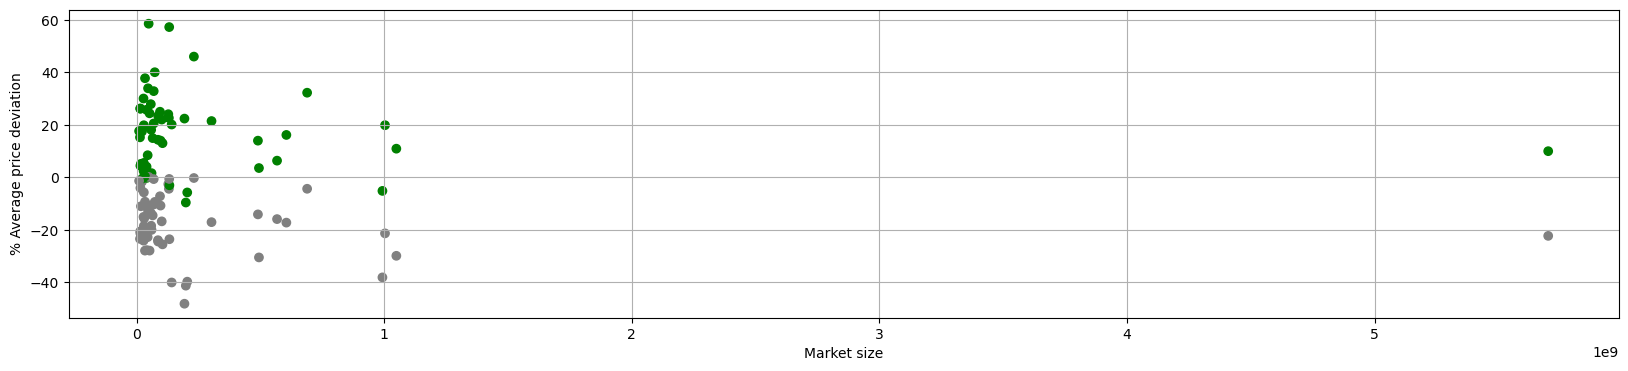

In [110]:
convencional_region_mean_total = df_cp_cleaned.groupby(['region','type']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)

for region in pd.unique(df_cp_cleaned['region']):
    convencional_region_mean_total.loc[(region, 'organic'),'Total Volume'] = convencional_region_mean_total.loc[(region, 'conventional'),'Total Volume']

new_convencional_region_mean_total= convencional_region_mean_total.reset_index(level='type') 

type_coloring= {'organic':'green', 'conventional':'gray'}

# display(new_df)
fig, ax= plt.subplots(figsize=(20,4))
x_values = new_convencional_region_mean_total['Total Volume']
total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = (new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= new_convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values, c=c_values)
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
plt.grid()

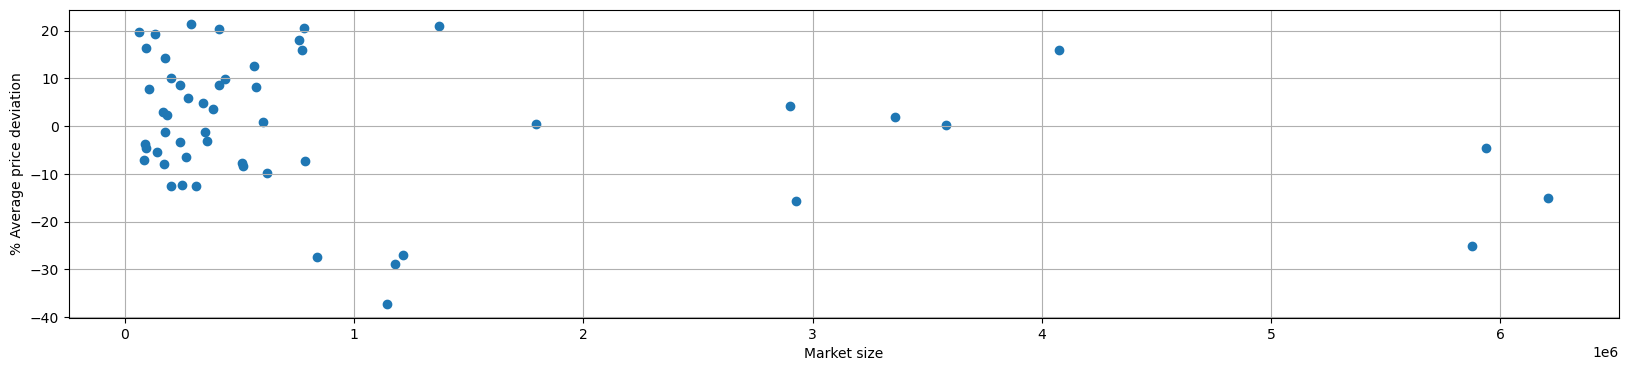

In [111]:
convencional_region_mean_total = df_convencionals.groupby('region').agg({'Total Volume':'mean', 'AveragePrice':'mean'})#.nlargest(6)
convencional_region_mean_total['region_class'] = convencional_region_mean_total.index.map(av.region_classification)

classification_colors = {'City':'green' ,'Region':'yellow' ,'GreaterRegion':'orange', 'State':'red'}


fig, ax= plt.subplots(figsize=(20,4))
x_values = convencional_region_mean_total['Total Volume']
total_mean = df_convencionals['AveragePrice'].mean()
y_values = (convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= convencional_region_mean_total['region_class'].map(classification_colors)


plt.scatter(x= x_values, y= y_values)
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
plt.grid()

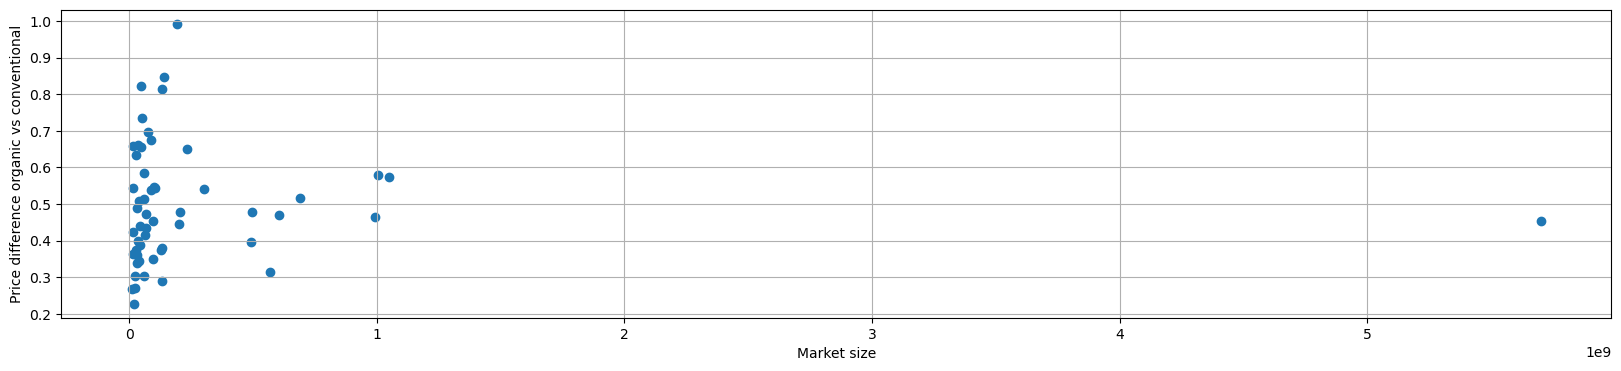

In [112]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
convencional_df = df_cp_cleaned[df_cp_cleaned['type']=='conventional']
organic_df = df_cp_cleaned[df_cp_cleaned['type']=='organic']

convencional_region_mean_total = convencional_df.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
organic_region_mean_total = organic_df.groupby('region').agg({'AveragePrice':'mean'})#.nlargest(6)

convencional_region_mean_total['Price difference'] = organic_region_mean_total['AveragePrice'] - convencional_region_mean_total['AveragePrice'] 

# display(new_df)
fig, ax= plt.subplots(figsize=(20,4))
x_values = convencional_region_mean_total['Total Volume']
# total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = convencional_region_mean_total['Price difference'] #(new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
# c_values= convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values)#, c=c_values)
plt.ylabel('Price difference organic vs conventional')
plt.xlabel('Market size')
plt.grid()

### REGRESIONES Y PROYECCIONES

#### Creación del modelo de regresión

#### Creación de modelo predictivo de ventas por MES usando los datos de años anteriores ( lineal y polinomica ) Calculo R2

#### Creación de modelo predictivo de ventas por TRIMESTRE usando los datos de años anteriores ( lineal y polinomica ) Calculo R2

#### Creación de modelo predictivo de ventas por AÑO usando los datos de años anteriores ( lineal y polinomica ) Calculo R2

#### Modelos de regresión multiple entre todas las variables según  apartado 5.6. En especial, precio medio y relación con diferentes calibres.Precio vs Total Bags

#### Analisis de coeficientes de regresion multiple. Afectación de cada variable al AvgPrice apartado 5.7

#### Modelos de regresión para diferenciar volumenes de ventas Apartado 5.8 . Calibres y AveragePrice.

#### Creación de modelo de regresión y polinómica de ventas totales sobre precio promedio ( por regiones o no ) apartado 5.9

#### Predicciones

#### Predicción de precio promedio según volumen aguacates y por tipo ( y por calibres ??) . Lineal y Polinomica. Calculo de R2